In [61]:
import os
os.chdir("..")

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor, AdaptParams, AdaptiveMixtureSampler

from production.utils import summarize_depths_by_return_period
from production.metrics import metrics
from production.plots import plot_return_period_summary, plot_two_return_period_summaries
from production.plots import plot_adaptive_evolution


In [63]:
watershed_names = ["Trinity","Kanawha","Duwamish","Denton"]

In [64]:
#Load data
watersheds = {}

for wname in watershed_names:
    ws = Preprocessor.load(
        config_path=f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{wname}/config.json"
    )
    watersheds[wname] = ws

In [65]:
#Full Monte Carlo summary
base_dir = "/workspaces/Importance-Sampling-for-SST/data/1_interim"
summary_filename = "fullmonte_summary.pq"

# --- load summaries ---
summaries = {}
for w in watershed_names:
    path = os.path.join(base_dir, w, summary_filename)
    df = pd.read_parquet(path)
    needed = {"RP","median_in","ci95_low_in","ci95_high_in"}
    if not needed <= set(df.columns):
        raise ValueError(f"{w}: summary missing columns {needed - set(df.columns)}")
    summaries[w] = df.sort_values("RP")

In [66]:
watershed = watersheds["Trinity"]

In [67]:
params = AdaptParams(
    mu_x_n=watershed.domain_stats["x"],
    mu_y_n=watershed.domain_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"] * 0.5,
    sd_y_n=watershed.watershed_stats["range_y"] * 0.5,

    mu_x_w=watershed.watershed_stats["x"],
    mu_y_w=watershed.watershed_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"],
    sd_y_w=watershed.domain_stats["range_y"],

    rho_n=-0.7,      # correlation narrow
    rho_w=0.5,       # correlation wide
    mix=0.5,         # initial mixture weight for narrow
)

sampler = AdaptiveMixtureSampler(
    data=watershed,                   
    params=params,
    precip_cube=watershed.cumulative_precip,
    seed=42
)

# Adapt does NOT take data or seed
history = sampler.adapt(num_iterations=10, samples_per_iter=1000, depth_threshold=50.8)

In [68]:
history

iter       n         ess  perplexity  hit_raw     hit_w  updated  \
0      0     NaN         NaN         NaN      NaN       NaN        0   
1      1  1000.0  648.067694    0.803151    0.474  0.555301        1   
2      2  1000.0  682.117468    0.838603    0.525  0.549147        1   
3      3  1000.0  720.971401    0.863254    0.587  0.550766        1   
4      4  1000.0  727.015826    0.865424    0.646  0.576816        1   
5      5  1000.0  756.701195    0.876182    0.612  0.513212        1   
6      6  1000.0  738.961014    0.865815    0.650  0.540203        1   
7      7  1000.0  705.916172    0.843132    0.625  0.503494        1   
8      8  1000.0  719.514091    0.855172    0.636  0.524340        1   
9      9  1000.0  709.283544    0.845246    0.648  0.530320        1   
10    10  1000.0  674.063769    0.831143    0.659  0.531051        1   

         mix         mu_x_n        mu_y_n         sd_x_n         sd_y_n  \
0   0.500000  445653.927772  1.016893e+06  196733.000007  222234.350353   
1   0.421536  253744.888732  1.063115e+06  170161.995521  171881.396913   
2   0.399231  119086.623111  1.059326e+06  164468.527635  147781.775284   
3   0.404074   26357.015031  1.058130e+06  147440.395023  138650.695876   
4   0.412969  -21585.688374  1.041886e+06  144288.372195  140471.581910   
5   0.418330  -29536.259329  1.005221e+06  139138.789510  147127.174563   
6   0.435143  -42291.134272  9.946600e+05  134436.462841  155662.448344   
7   0.445364  -57382.777981  9.893217e+05  133413.957792  156800.875503   
8   0.459909  -59513.187513  9.792862e+05  130124.278175  160267.844558   
9   0.474615  -62245.719884  9.787331e+05  132264.705193  162390.872199   
10  0.484859  -52982.190465  9.736543e+05  126810.461691  166917.850930   

       rho_n  
0  -0.700000  
1  -0.466046  
2  -0.380597  
3  -0.328081  
4  -0.264315  
5  -0.201199  
6  -0.125489  
7  -0.089245  
8  -0.032651  
9  -0.072181  
10 -0.000744

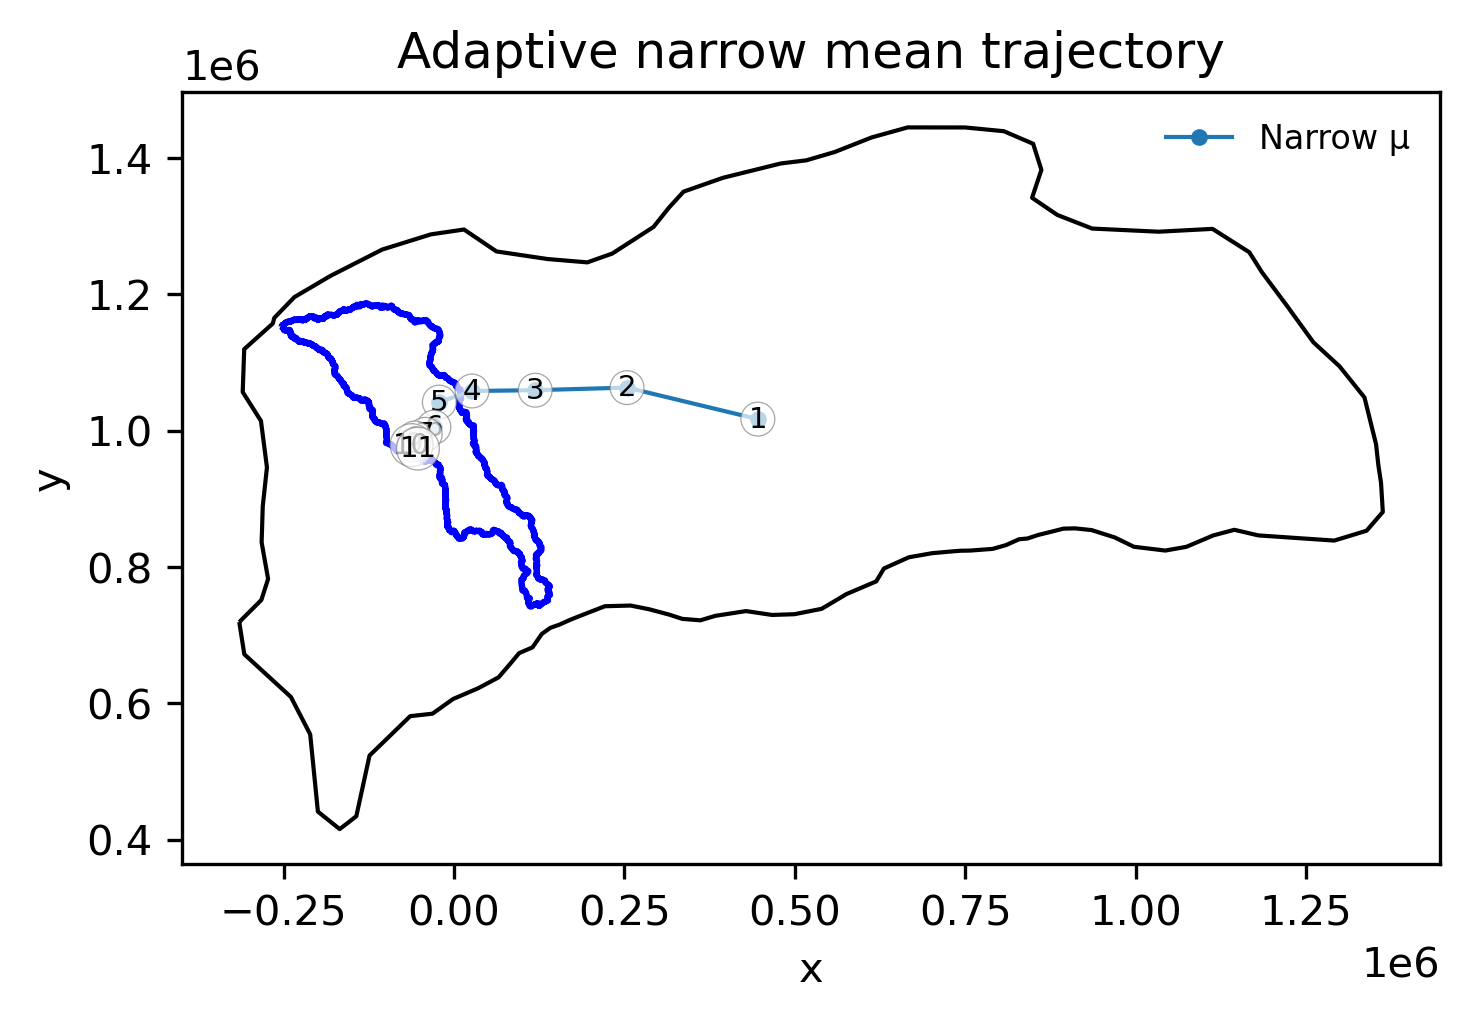

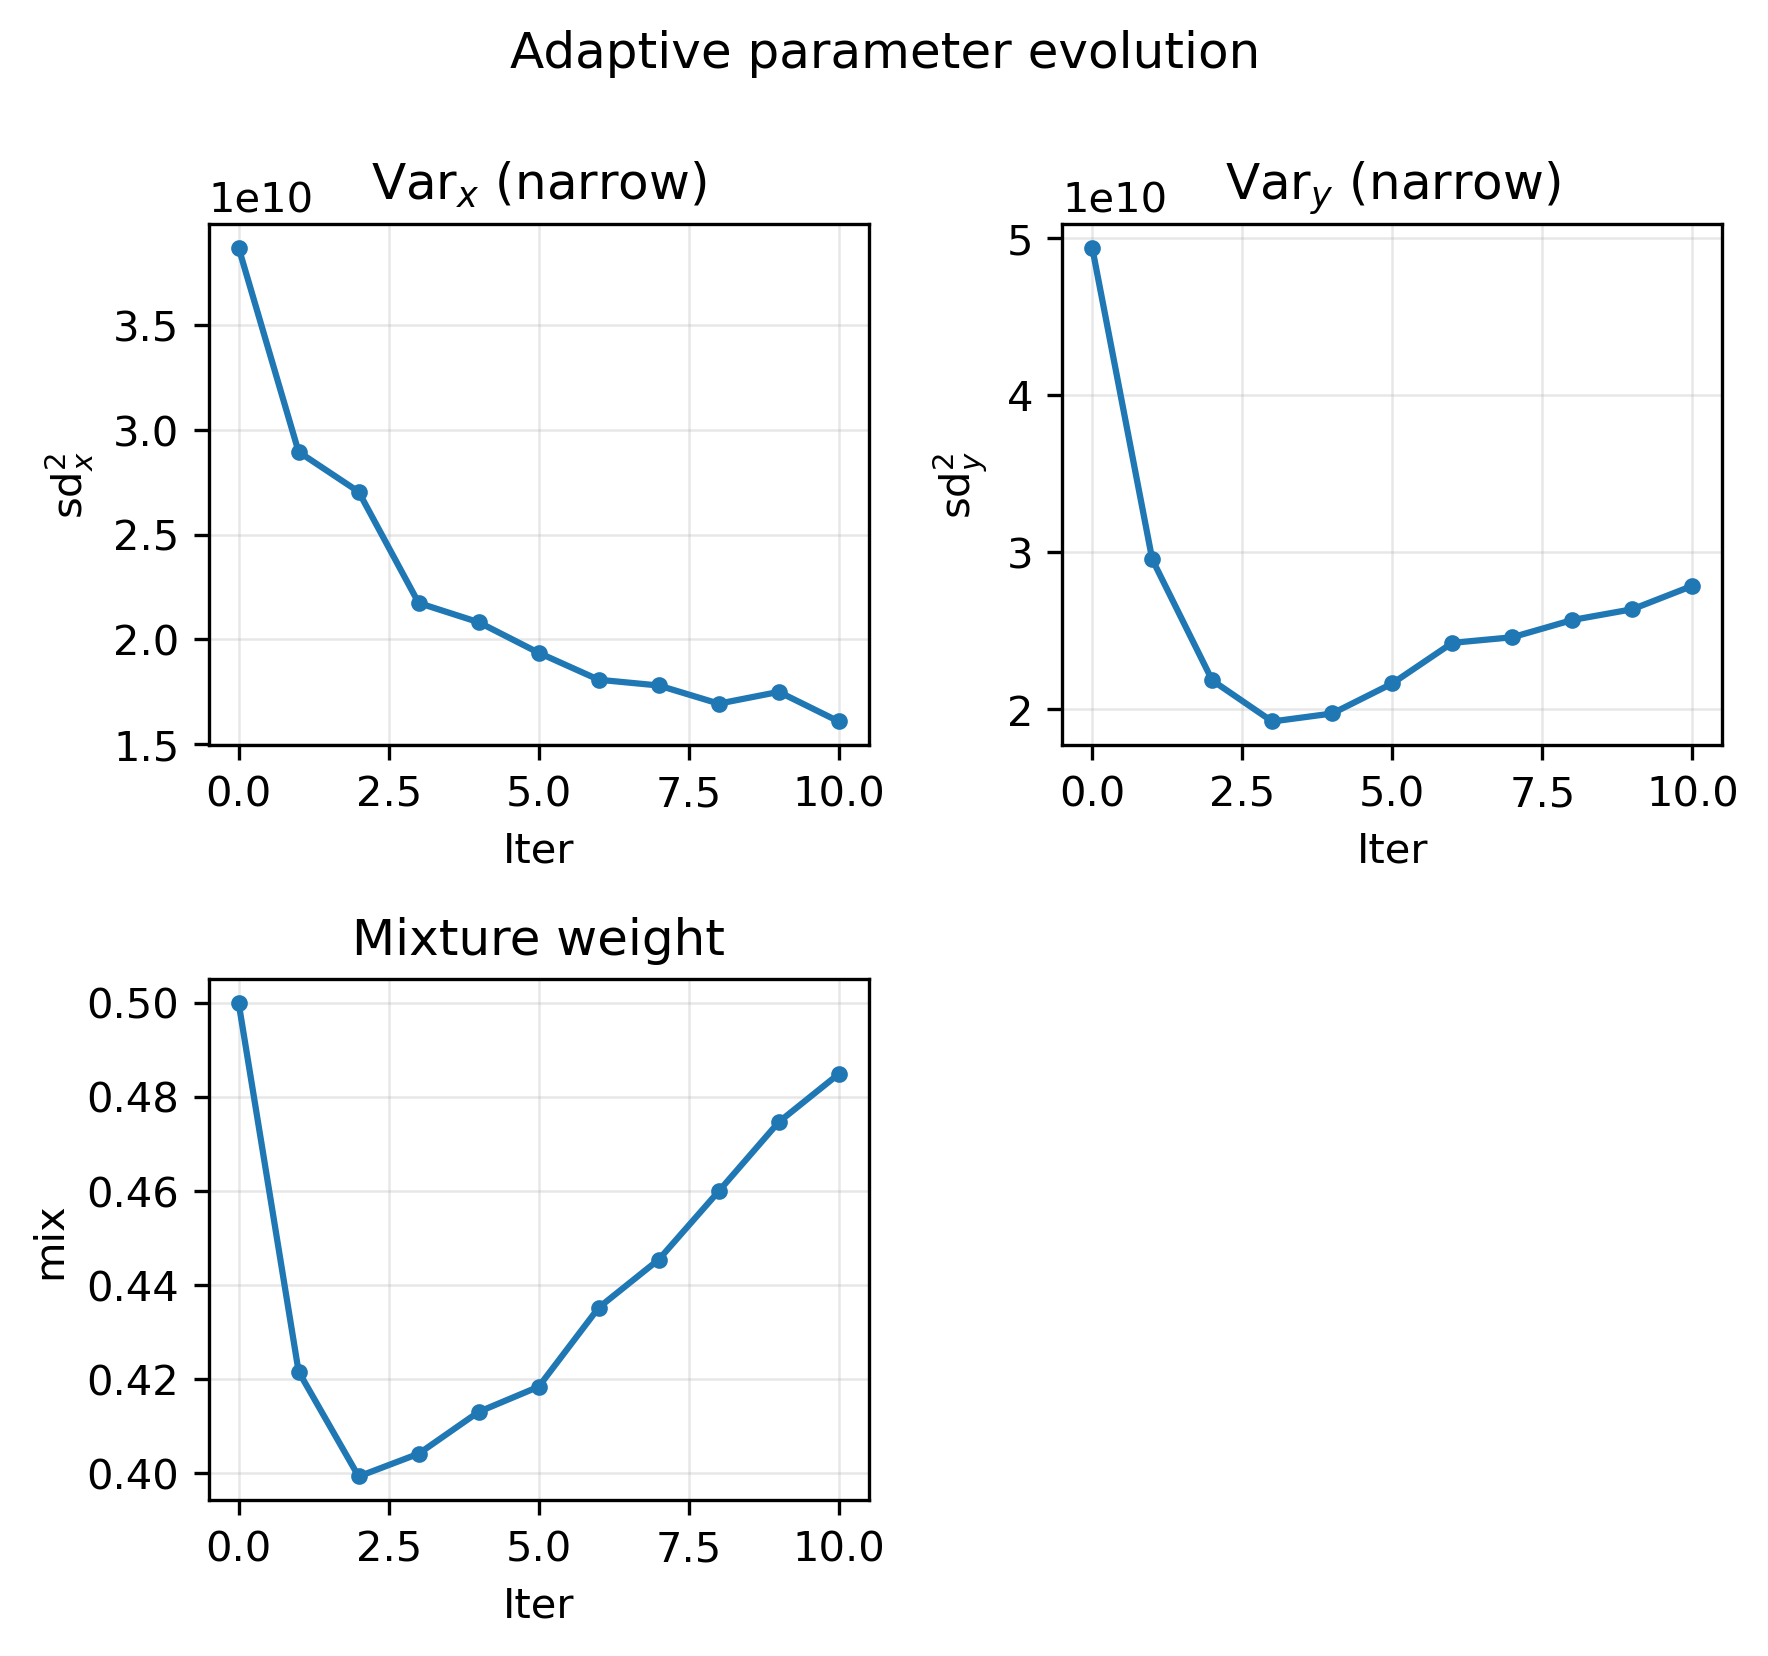

In [69]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="trinity_ais")

In [70]:
final_df = sampler.sample_final(n=12000, num_realizations=50, with_depths=True)

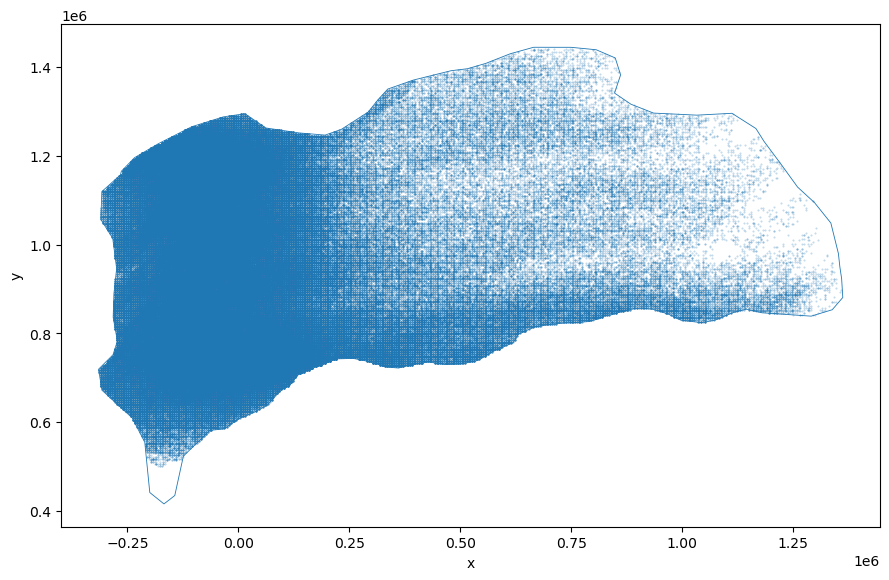

In [72]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(final_df.newx, final_df.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [73]:
adaptive_summary = summarize_depths_by_return_period(
    df=final_df,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
    use_common_min=True
)

In [74]:
m = metrics(summaries["Trinity"],adaptive_summary)
m

n_points  rp_min_used  rp_max_used  rmse_mean  rmse_median  rmse_ci95_low  \
0      1999          2.0       2000.0    0.02311     0.030466       0.075824   

   rmse_ci95_high  rmse_ci90_low  rmse_ci90_high   me_mean  ...  me_ci95_low  \
0        0.049909       0.046977        0.039753 -0.015932  ...    -0.061214   

   me_ci95_high  me_ci90_low  me_ci90_high  diff_at_maxrp_mean  \
0     -0.012112    -0.025989      -0.01131           -0.026458   

   diff_at_maxrp_median  diff_at_maxrp_ci95_low  diff_at_maxrp_ci95_high  \
0             -0.050865               -0.035861                -0.024666   

   diff_at_maxrp_ci90_low  diff_at_maxrp_ci90_high  
0               -0.040724                 -0.02301  

[1 rows x 21 columns]

In [75]:
adaptive_summary

RP   mean_in  median_in  ci90_low_in  ci90_high_in  ci95_low_in  \
0        2  3.834500   3.832652     3.793032      3.871722     3.789041   
1        3  4.331451   4.334162     4.276688      4.396005     4.252494   
2        4  4.611087   4.606219     4.547941      4.660375     4.542131   
3        5  4.796554   4.799909     4.732453      4.857711     4.725003   
4        6  4.931326   4.927344     4.878765      4.992402     4.867769   
...    ...       ...        ...          ...           ...          ...   
1994  1996  9.139819   9.144352     8.925257      9.267102     8.917930   
1995  1997  9.139909   9.144390     8.925279      9.267186     8.918039   
1996  1998  9.139998   9.144429     8.925301      9.267271     8.918148   
1997  1999  9.140087   9.144467     8.925323      9.267355     8.918257   
1998  2000  9.140176   9.144505     8.925345      9.267440     8.918366   

      ci95_high_in  n_realizations  n_samples_per_realization  
0         3.878196              50                      12000  
1         4.402017              50                      12000  
2         4.682204              50                      12000  
3         4.880236              50                      12000  
4         5.004572              50                      12000  
...            ...             ...                        ...  
1994      9.271976              50                      12000  
1995      9.272102              50                      12000  
1996      9.272228              50                      12000  
1997      9.272354              50                      12000  
1998      9.272480              50                      12000  

[1999 rows x 9 columns]

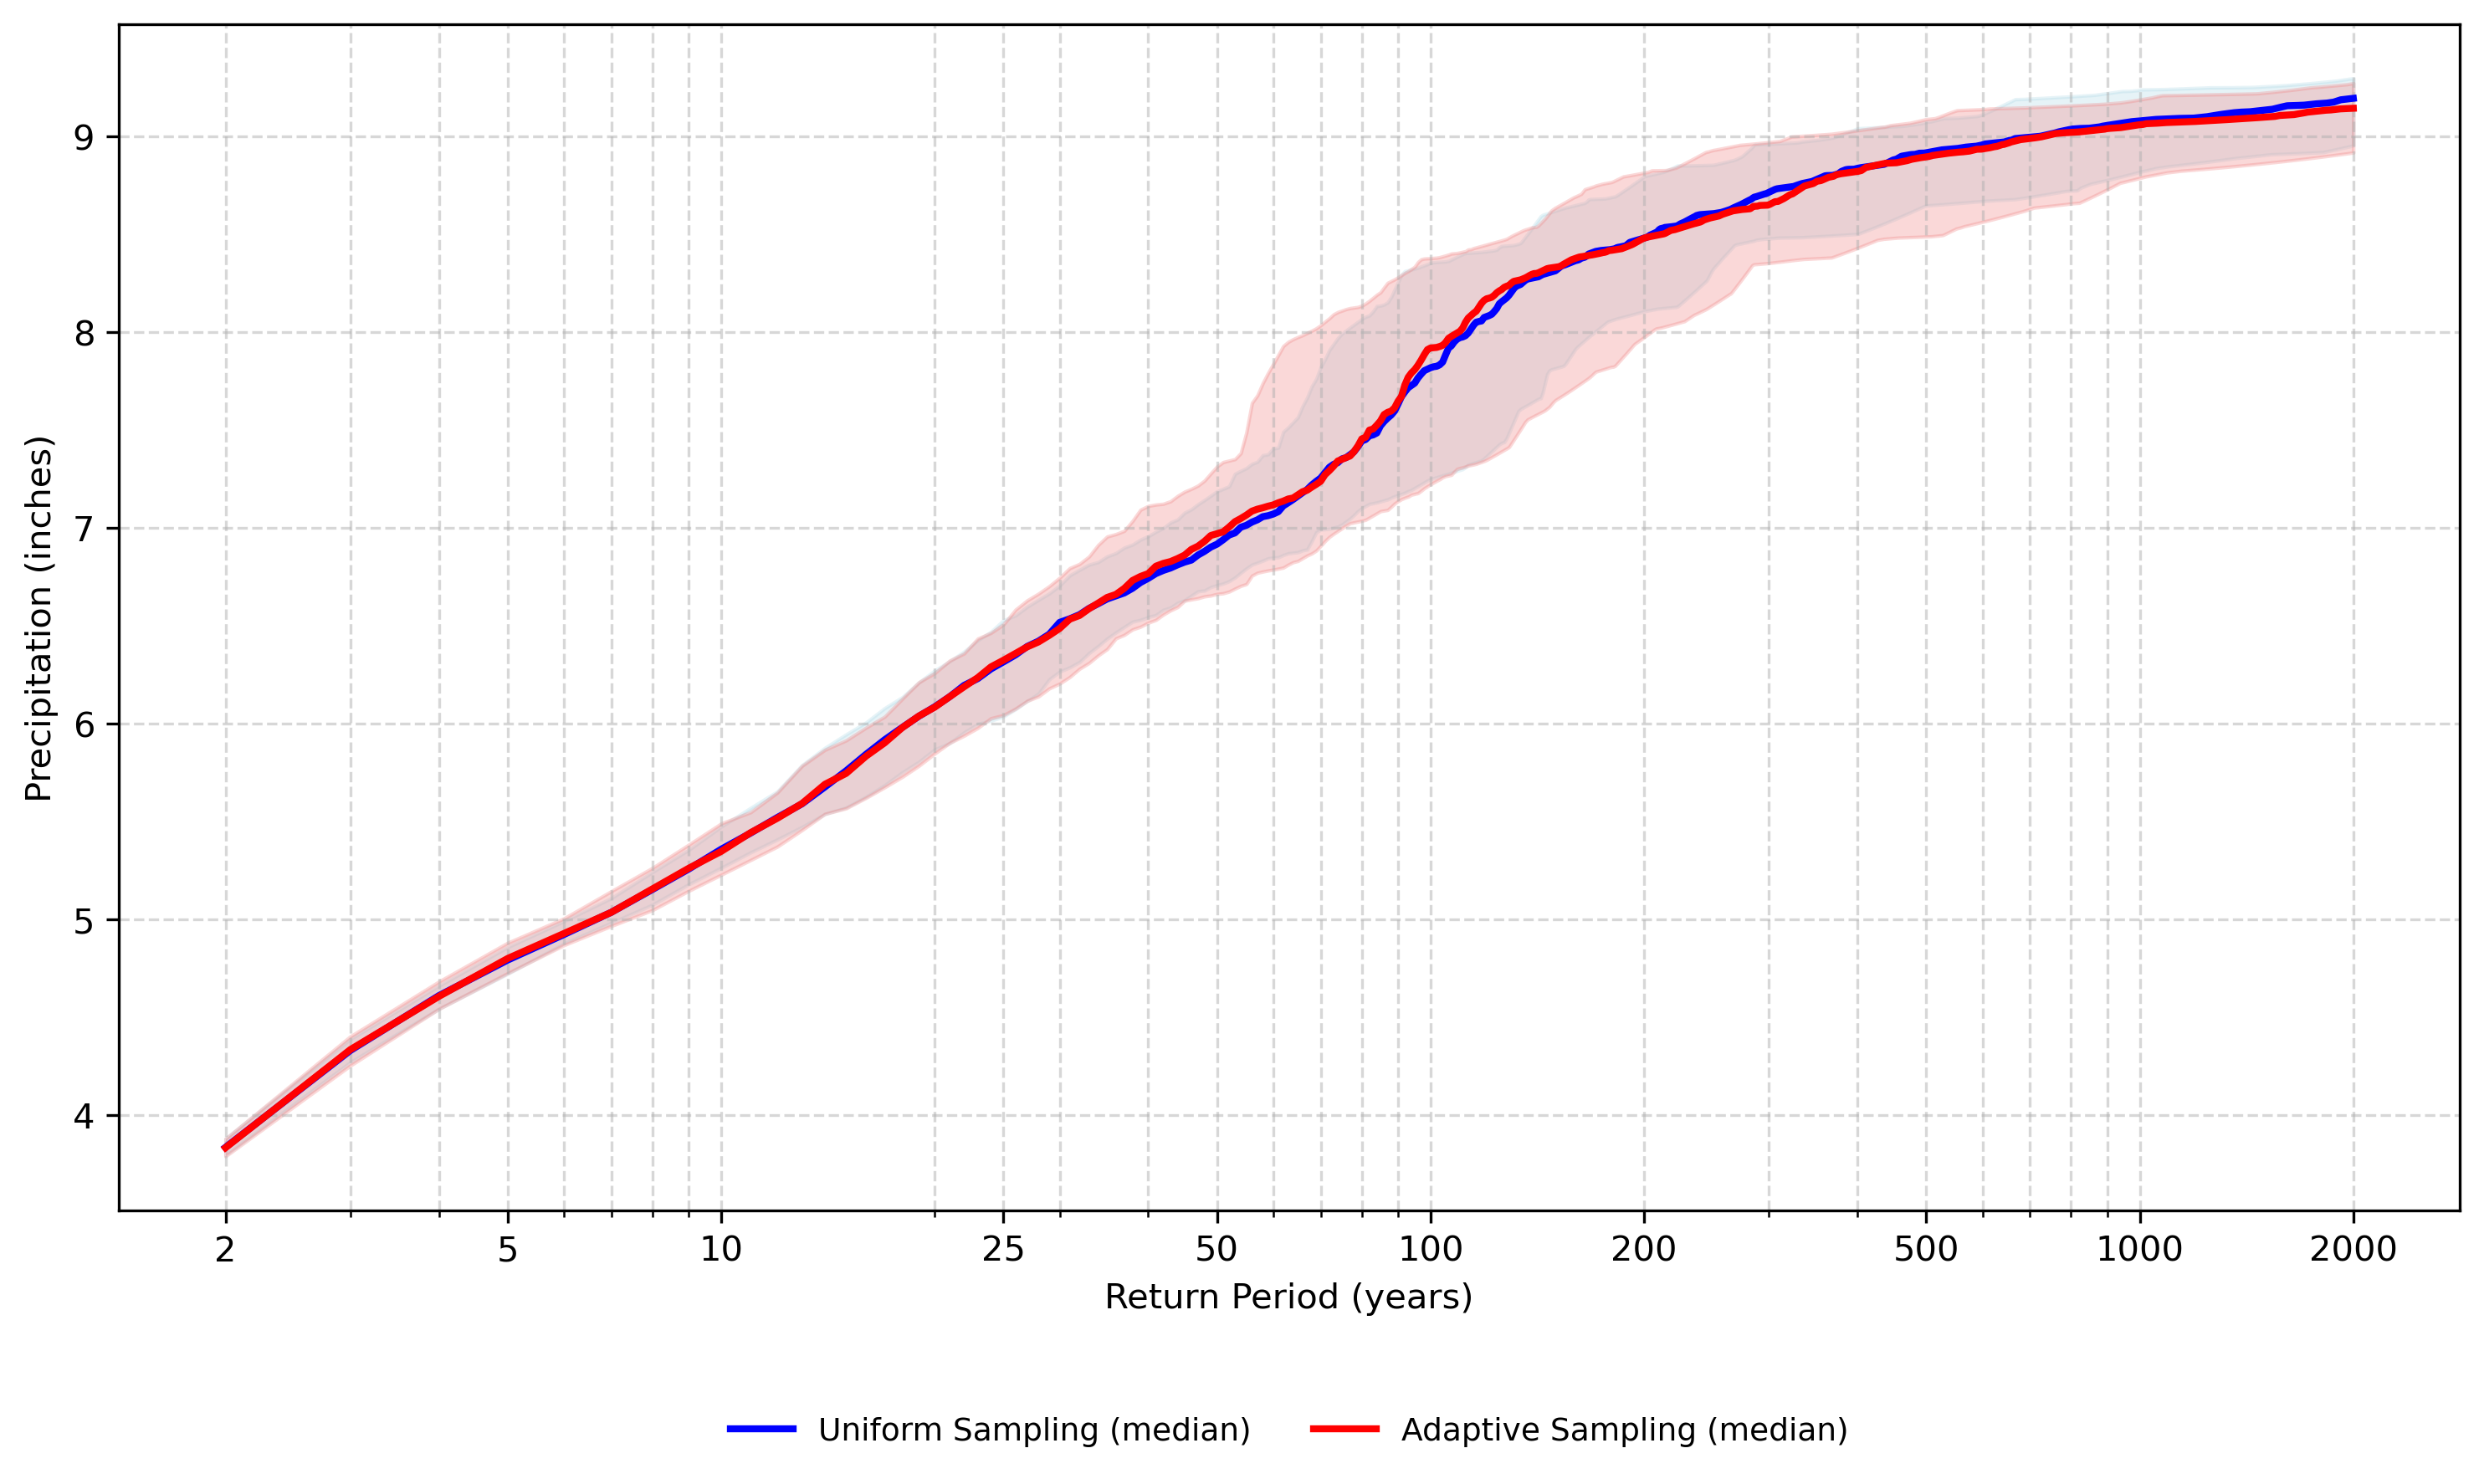

In [76]:
plot_two_return_period_summaries(
    summary1= summaries["Trinity"],          # your first summary DataFrame
    summary2=adaptive_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Adaptive Sampling",
    title=""
)

In [29]:
watershed = watersheds["Kanawha"]

In [63]:
params = AdaptParams(
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"],
    sd_y_n=watershed.watershed_stats["range_y"],

    mu_x_w=watershed.watershed_stats["x"],
    mu_y_w=watershed.watershed_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"],
    sd_y_w=watershed.domain_stats["range_y"],

    rho_n=-0.1,      # correlation narrow
    rho_w=0.1,       # correlation wide
    mix=0.3,         # initial mixture weight for narrow
)

sampler = AdaptiveMixtureSampler(
    data=watershed,                   
    params=params,
    precip_cube=watershed.cumulative_precip,
    seed=42
)

# Adapt does NOT take data or seed
history = sampler.adapt(num_iterations=10, samples_per_iter=1000, depth_threshold=0.0)

In [64]:
history

iter       n         ess  perplexity  hit_raw     hit_w  updated  \
0      0     NaN         NaN         NaN      NaN       NaN        0   
1      1  1000.0  983.457229    0.991746      1.0  0.999999        1   
2      2  1000.0  959.587710    0.979643      1.0  0.999999        1   
3      3  1000.0  919.657573    0.959150      1.0  0.999999        1   
4      4  1000.0  871.636044    0.934010      1.0  0.999999        1   
5      5  1000.0  832.424623    0.913393      1.0  0.999999        1   
6      6  1000.0  804.858453    0.899717      1.0  0.999999        1   
7      7  1000.0  757.203679    0.875134      1.0  0.999999        1   
8      8  1000.0  783.441528    0.887396      1.0  0.999999        1   
9      9  1000.0  767.893699    0.878965      1.0  0.999999        1   
10    10  1000.0  742.835595    0.867095      1.0  0.999999        1   

         mix        mu_x_n        mu_y_n         sd_x_n         sd_y_n  \
0   0.300000  1.308114e+06  1.738215e+06  218409.555672  316501.199029   
1   0.309935  1.283523e+06  1.666262e+06  159118.574553  207141.400252   
2   0.345358  1.264101e+06  1.636097e+06  141286.733332  172322.782743   
3   0.382824  1.255882e+06  1.618098e+06  136518.315717  151726.259718   
4   0.420048  1.247141e+06  1.604169e+06  134208.735695  142520.426549   
5   0.457071  1.250783e+06  1.605274e+06  133061.199429  139037.855562   
6   0.491398  1.243677e+06  1.596205e+06  130225.990356  135639.251980   
7   0.518453  1.237884e+06  1.588602e+06  131465.491308  136324.421827   
8   0.550132  1.244080e+06  1.586329e+06  134011.234161  133088.896762   
9   0.570849  1.237539e+06  1.581367e+06  133387.248749  133317.350399   
10  0.593759  1.246730e+06  1.589511e+06  132587.089502  130459.064315   

       rho_n  
0  -0.100000  
1   0.334860  
2   0.473586  
3   0.519343  
4   0.551979  
5   0.566909  
6   0.581981  
7   0.594427  
8   0.599966  
9   0.591388  
10  0.569194

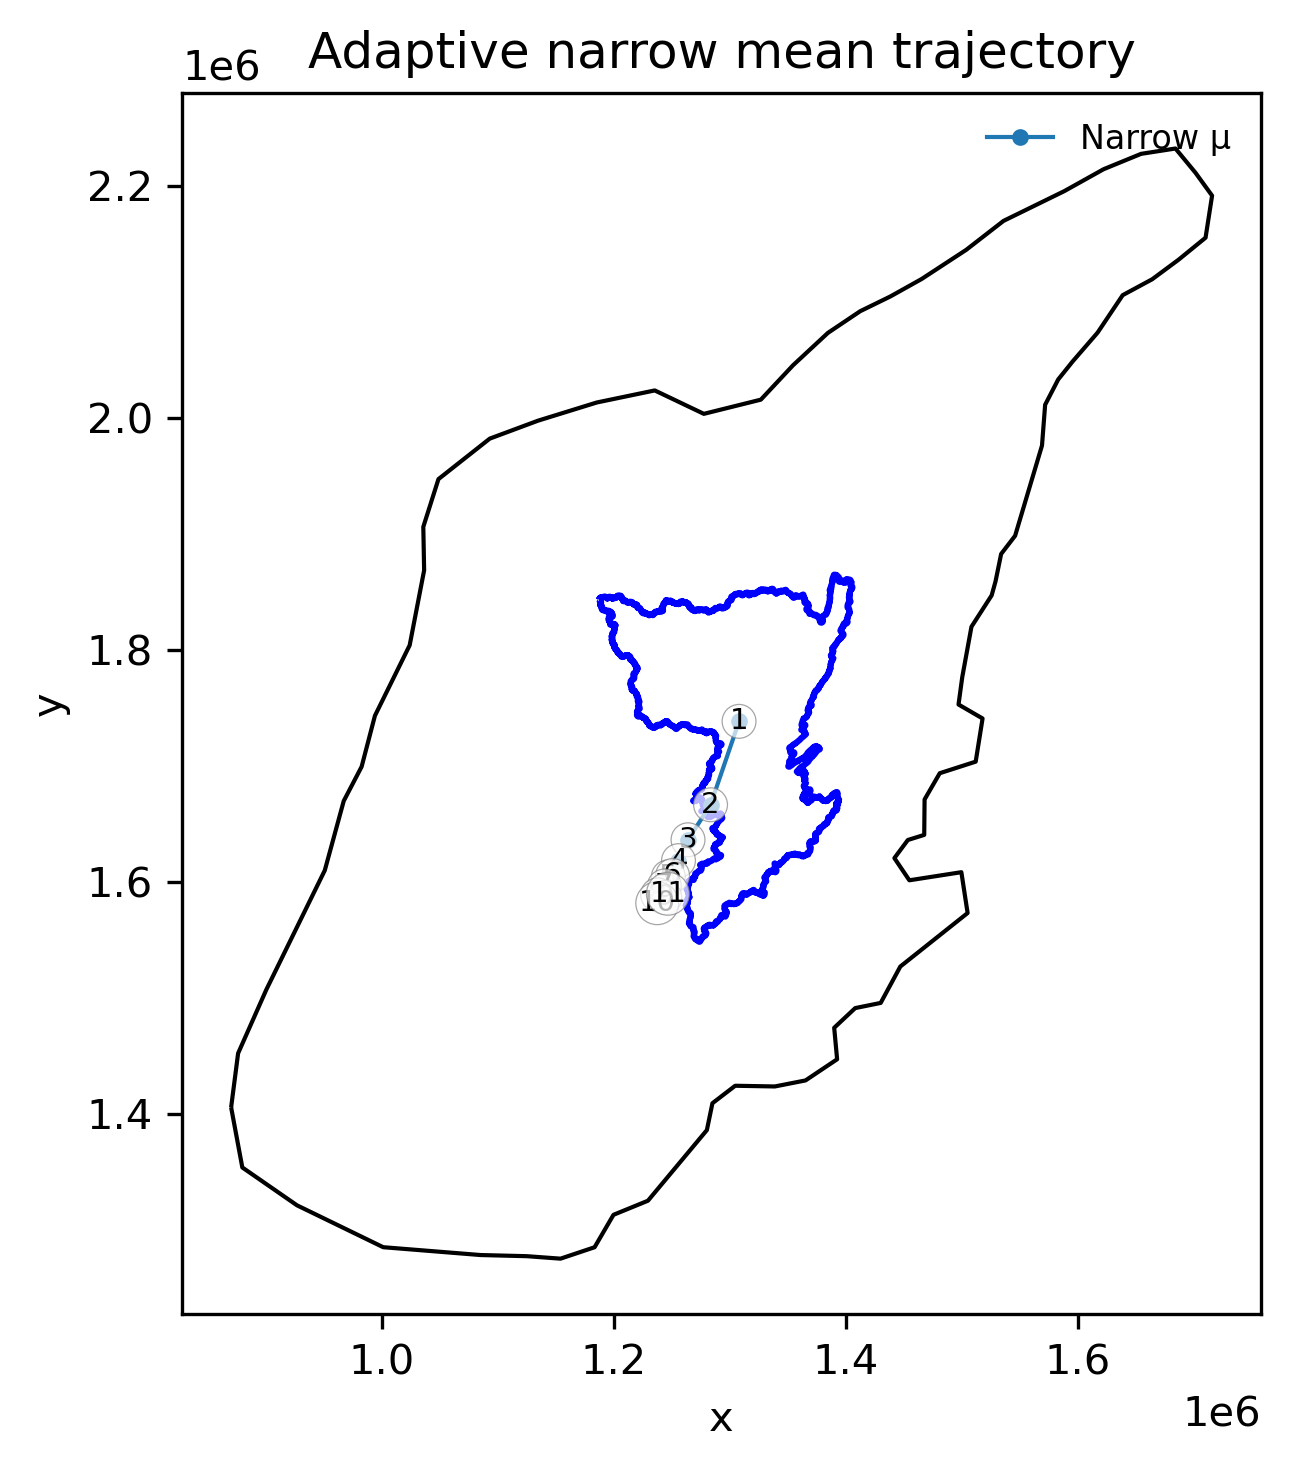

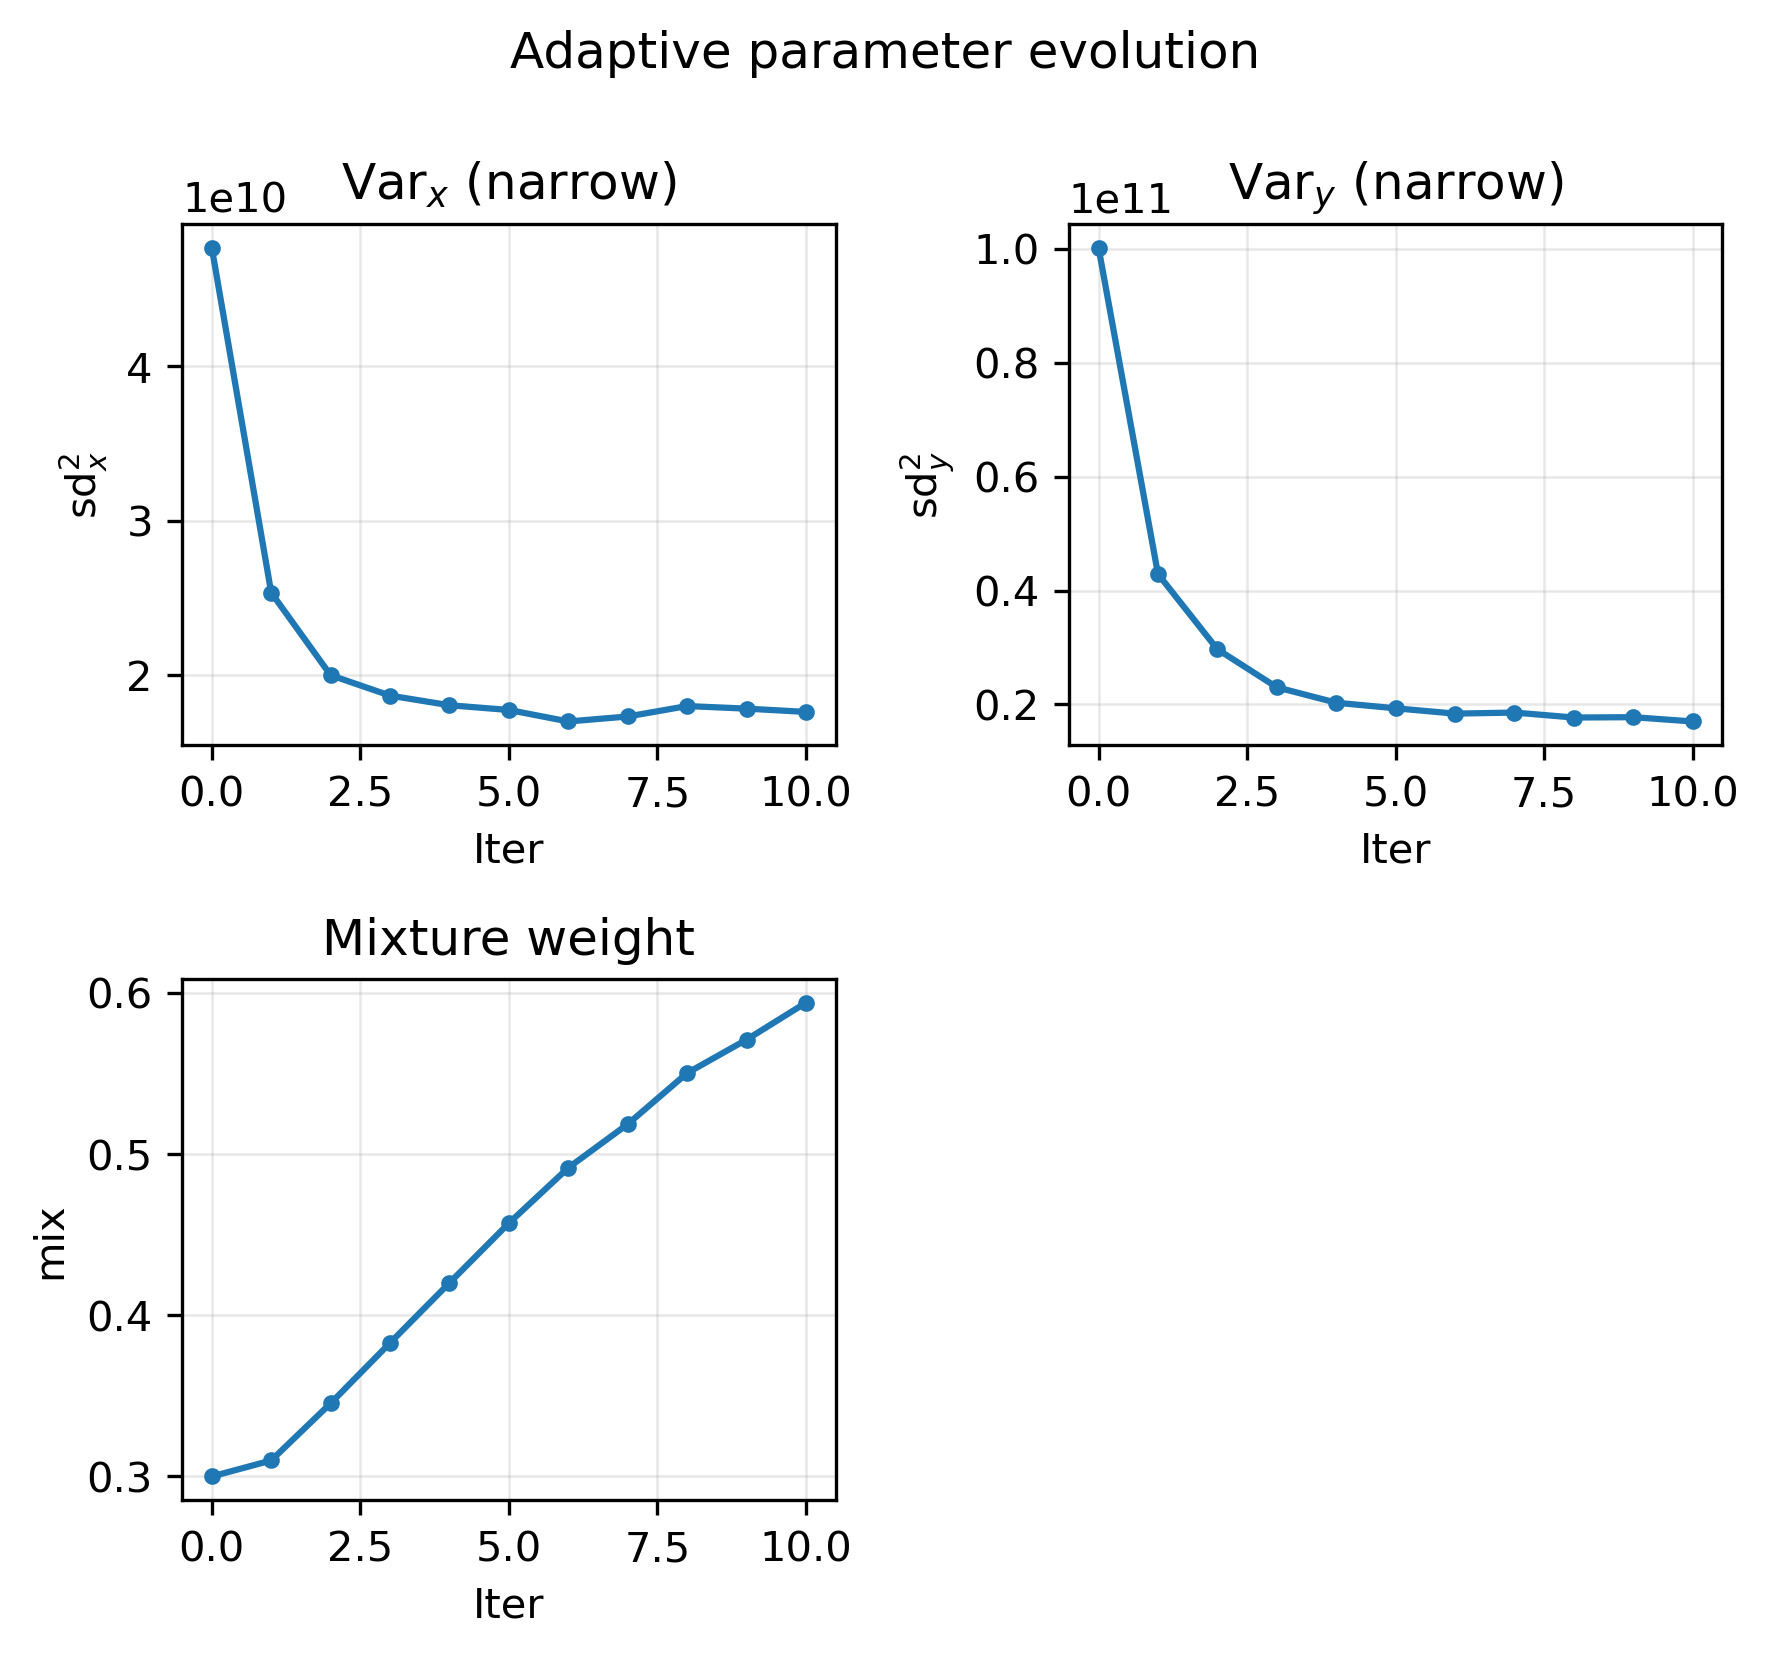

In [65]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="trinity_ais")

In [66]:
final_df = sampler.sample_final(n=14000, num_realizations=50, with_depths=True)

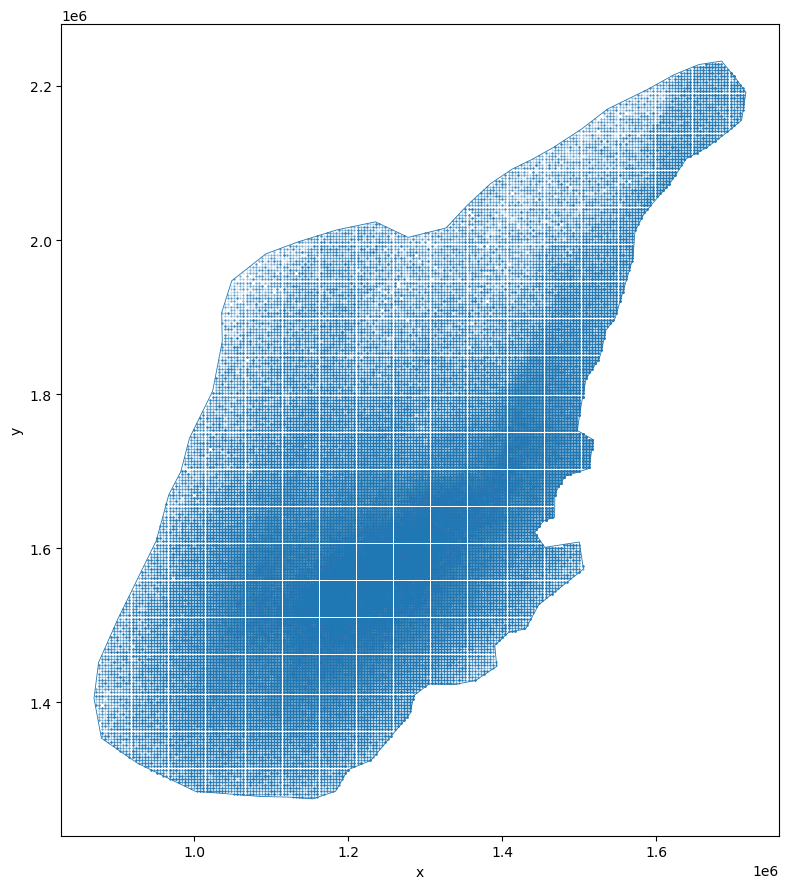

In [67]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(final_df.newx, final_df.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [68]:
adaptive_summary = summarize_depths_by_return_period(
    df=final_df,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
    use_common_min=True
)

In [ ]:
m = metrics(summaries["Kanawha"],adaptive_summary)
m

n_points  rp_min_used  rp_max_used  rmse_mean  rmse_median  rmse_ci95_low  \
0      1999          2.0       2000.0   3.453021     3.459518       3.425934   

   rmse_ci95_high  rmse_ci90_low  rmse_ci90_high   me_mean  ...  me_ci95_low  \
0        3.478358       3.419064        3.479299 -3.440096  ...    -3.407777   

   me_ci95_high  me_ci90_low  me_ci90_high  diff_at_maxrp_mean  \
0     -3.468188    -3.401992     -3.468815           -3.535025   

   diff_at_maxrp_median  diff_at_maxrp_ci95_low  diff_at_maxrp_ci95_high  \
0             -3.543331               -3.533499                 -3.56091   

   diff_at_maxrp_ci90_low  diff_at_maxrp_ci90_high  
0               -3.501048                -3.559164  

[1 rows x 21 columns]

In [70]:
adaptive_summary

RP   mean_in  median_in  ci90_low_in  ci90_high_in  ci95_low_in  \
0        2  2.711478   2.712668     2.680347      2.743501     2.677655   
1        3  3.044897   3.043629     3.003885      3.083352     3.001896   
2        4  3.255341   3.259861     3.208051      3.306887     3.197343   
3        5  3.414221   3.418603     3.349259      3.473415     3.344694   
4        6  3.535466   3.539242     3.479086      3.584067     3.474392   
...    ...       ...        ...          ...           ...          ...   
1994  1996  5.631442   5.652026     5.464515      5.731143     5.420378   
1995  1997  5.631484   5.652029     5.464642      5.731179     5.420466   
1996  1998  5.631526   5.652032     5.464768      5.731215     5.420553   
1997  1999  5.631568   5.652036     5.464895      5.731250     5.420641   
1998  2000  5.631609   5.652039     5.465021      5.731286     5.420728   

      ci95_high_in  n_realizations  n_samples_per_realization  
0         2.747904              50                      14000  
1         3.095801              50                      14000  
2         3.311508              50                      14000  
3         3.481466              50                      14000  
4         3.602205              50                      14000  
...            ...             ...                        ...  
1994      5.736201              50                      14000  
1995      5.736209              50                      14000  
1996      5.736218              50                      14000  
1997      5.736227              50                      14000  
1998      5.736235              50                      14000  

[1999 rows x 9 columns]

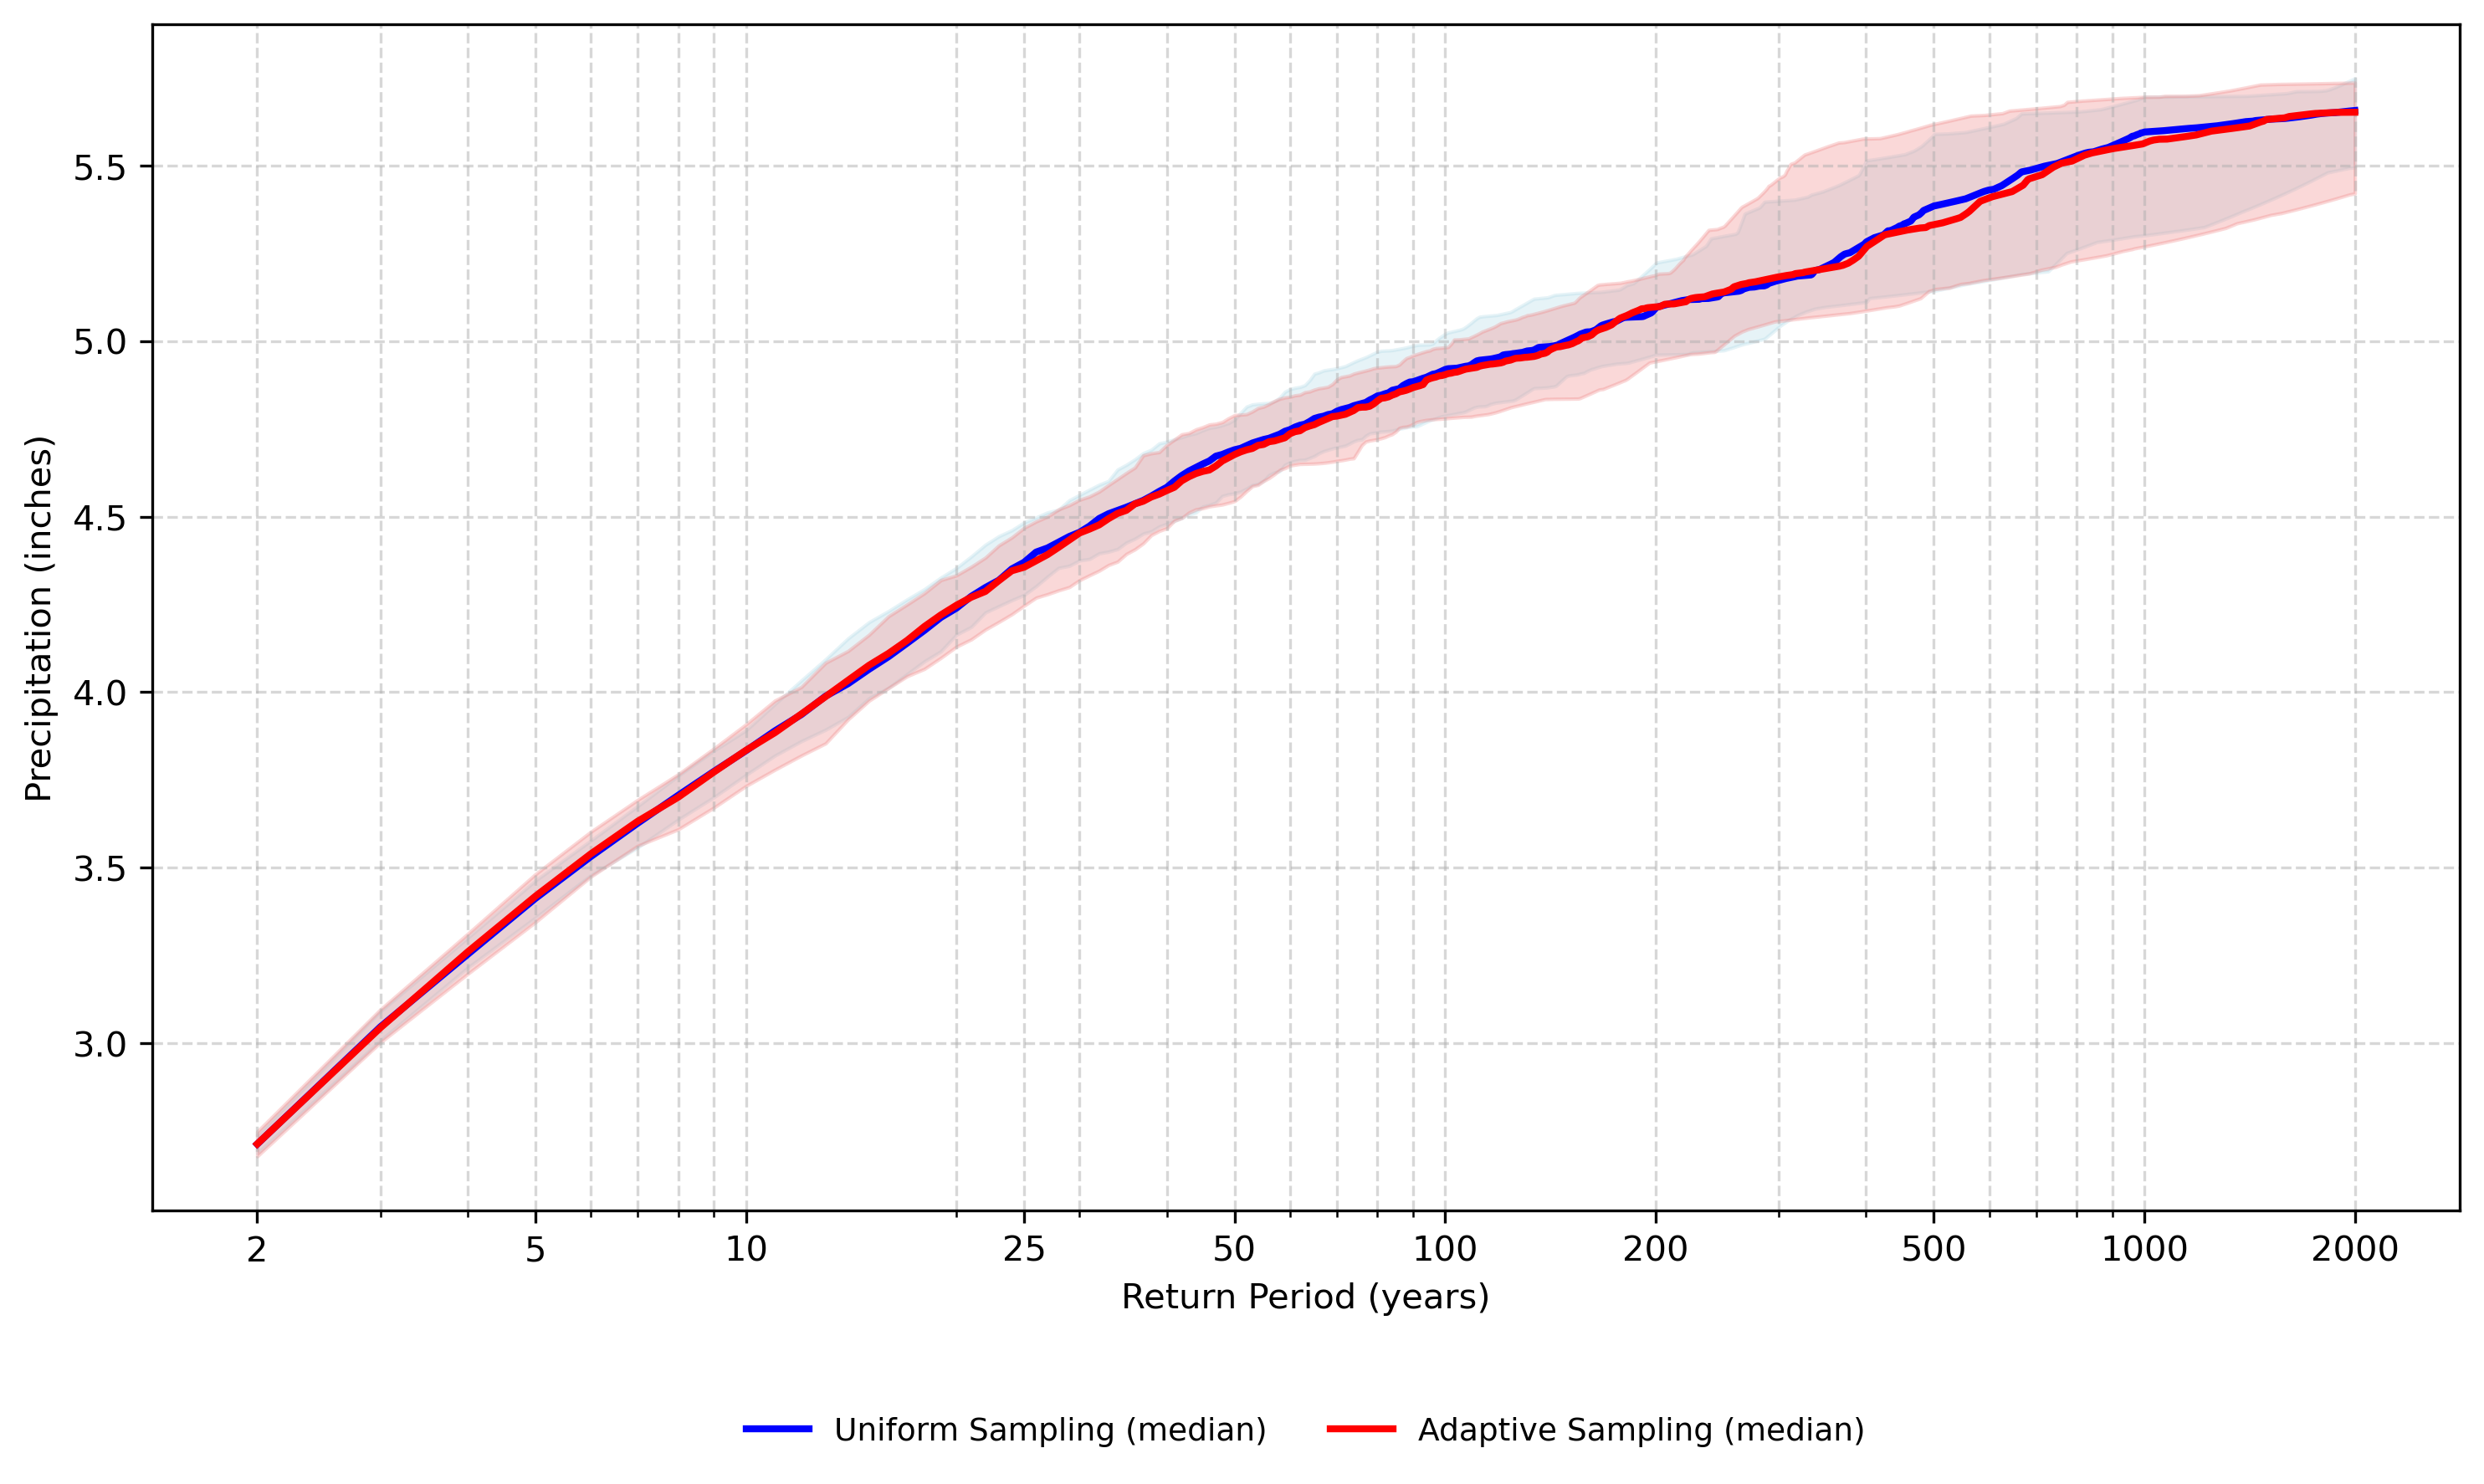

In [71]:
plot_two_return_period_summaries(
    summary1= summaries["Kanawha"],          # your first summary DataFrame
    summary2=adaptive_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Adaptive Sampling",
    title=""
)

In [72]:
watershed = watersheds["Duwamish"]

In [73]:
params = AdaptParams(
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"],
    sd_y_n=watershed.watershed_stats["range_y"],

    mu_x_w=watershed.watershed_stats["x"],
    mu_y_w=watershed.watershed_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"],
    sd_y_w=watershed.domain_stats["range_y"],

    rho_n=-0.1,      # correlation narrow
    rho_w=0.1,       # correlation wide
    mix=0.3,         # initial mixture weight for narrow
)

sampler = AdaptiveMixtureSampler(
    data=watershed,                   
    params=params,
    precip_cube=watershed.cumulative_precip,
    seed=42
)

# Adapt does NOT take data or seed
history = sampler.adapt(num_iterations=10, samples_per_iter=1000, depth_threshold=0.0)

In [74]:
history

iter       n         ess  perplexity  hit_raw     hit_w  updated  \
0      0     NaN         NaN         NaN      NaN       NaN        0   
1      1  1000.0  743.202955    0.858276      1.0  0.999999        1   
2      2  1000.0  657.624537    0.807418      1.0  0.999999        1   
3      3  1000.0  622.484221    0.785191      1.0  0.999999        1   
4      4  1000.0  562.720093    0.743608      1.0  0.999999        1   
5      5  1000.0  516.003771    0.712389      1.0  0.999999        1   
6      6  1000.0  539.127443    0.728792      1.0  0.999999        1   
7      7  1000.0  506.287365    0.712661      1.0  0.999999        1   
8      8  1000.0  486.529208    0.709880      1.0  0.999999        1   
9      9  1000.0  496.973474    0.712423      1.0  0.999999        1   
10    10  1000.0  435.742021    0.679260      1.0  0.999999        1   

         mix        mu_x_n        mu_y_n        sd_x_n        sd_y_n     rho_n  
0   0.300000 -1.942311e+06  2.965860e+06  69459.812896  67306.945629 -0.100000  
1   0.334157 -1.934528e+06  2.977585e+06  51253.798015  63913.702129  0.222517  
2   0.380873 -1.929361e+06  2.984624e+06  44489.722952  64064.426903  0.380077  
3   0.430912 -1.925679e+06  2.992566e+06  41962.375478  66556.114786  0.425574  
4   0.468716 -1.925770e+06  2.994902e+06  41923.206248  67771.691273  0.445605  
5   0.498198 -1.923779e+06  2.999688e+06  43589.821536  69528.898771  0.462193  
6   0.533694 -1.921121e+06  3.001407e+06  44556.280769  72965.550647  0.446979  
7   0.558876 -1.920424e+06  2.998554e+06  42768.362218  75204.317202  0.473943  
8   0.584232 -1.922741e+06  2.997702e+06  42924.679174  72654.034407  0.499170  
9   0.613356 -1.922689e+06  2.999140e+06  42333.587211  74325.604680  0.461053  
10  0.639174 -1.922104e+06  2.999447e+06  44003.513892  77175.651356  0.519176

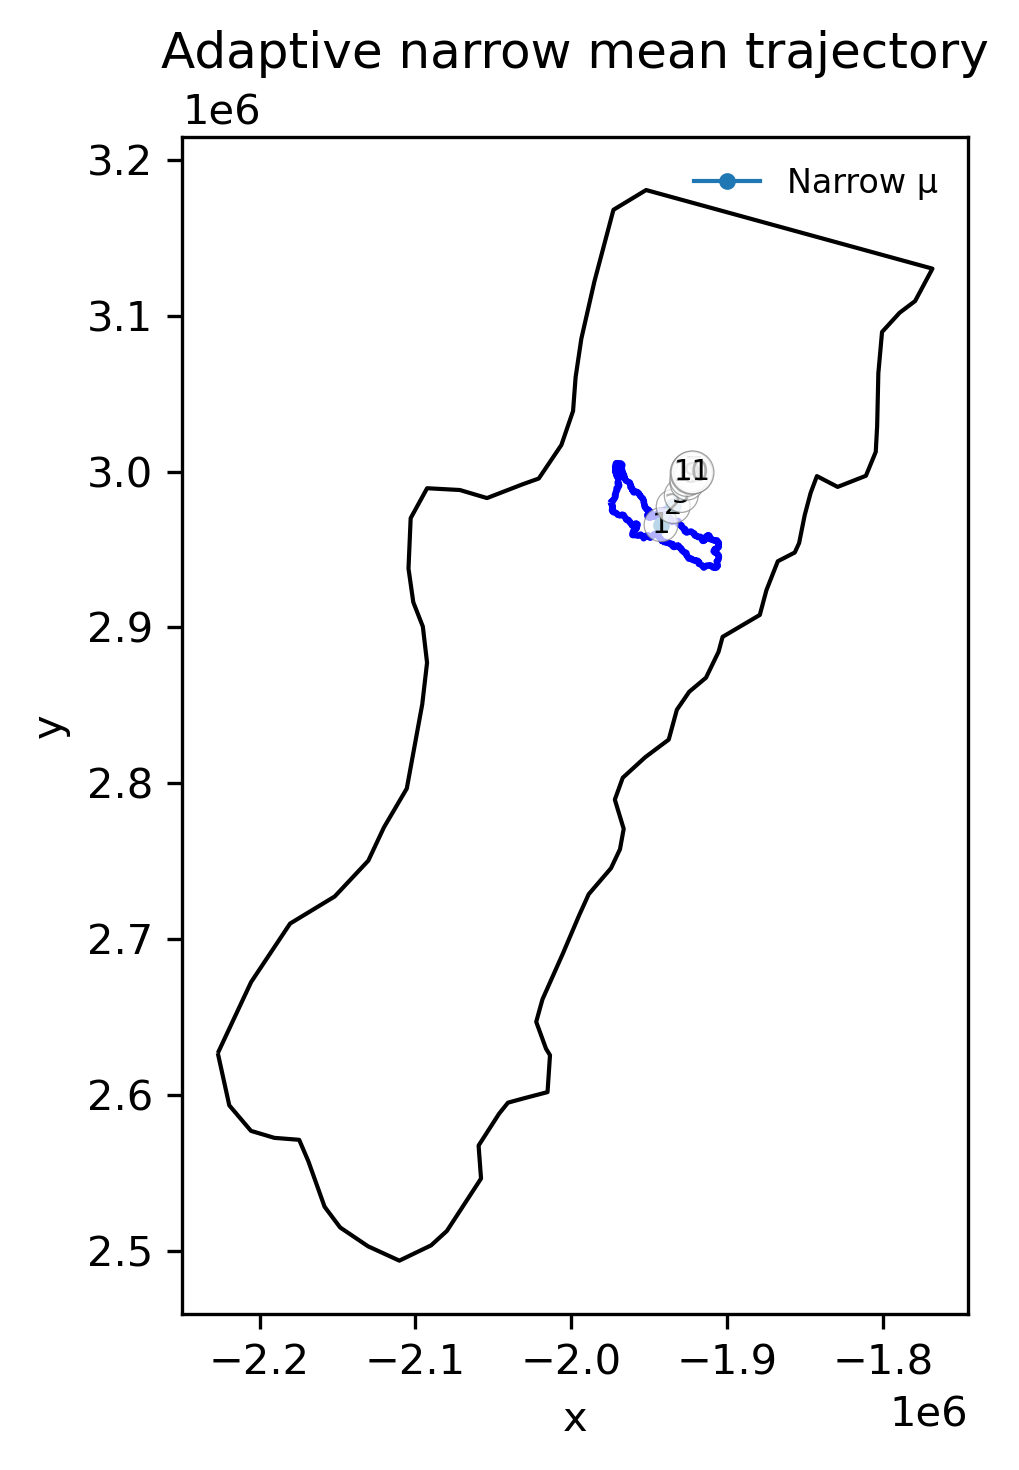

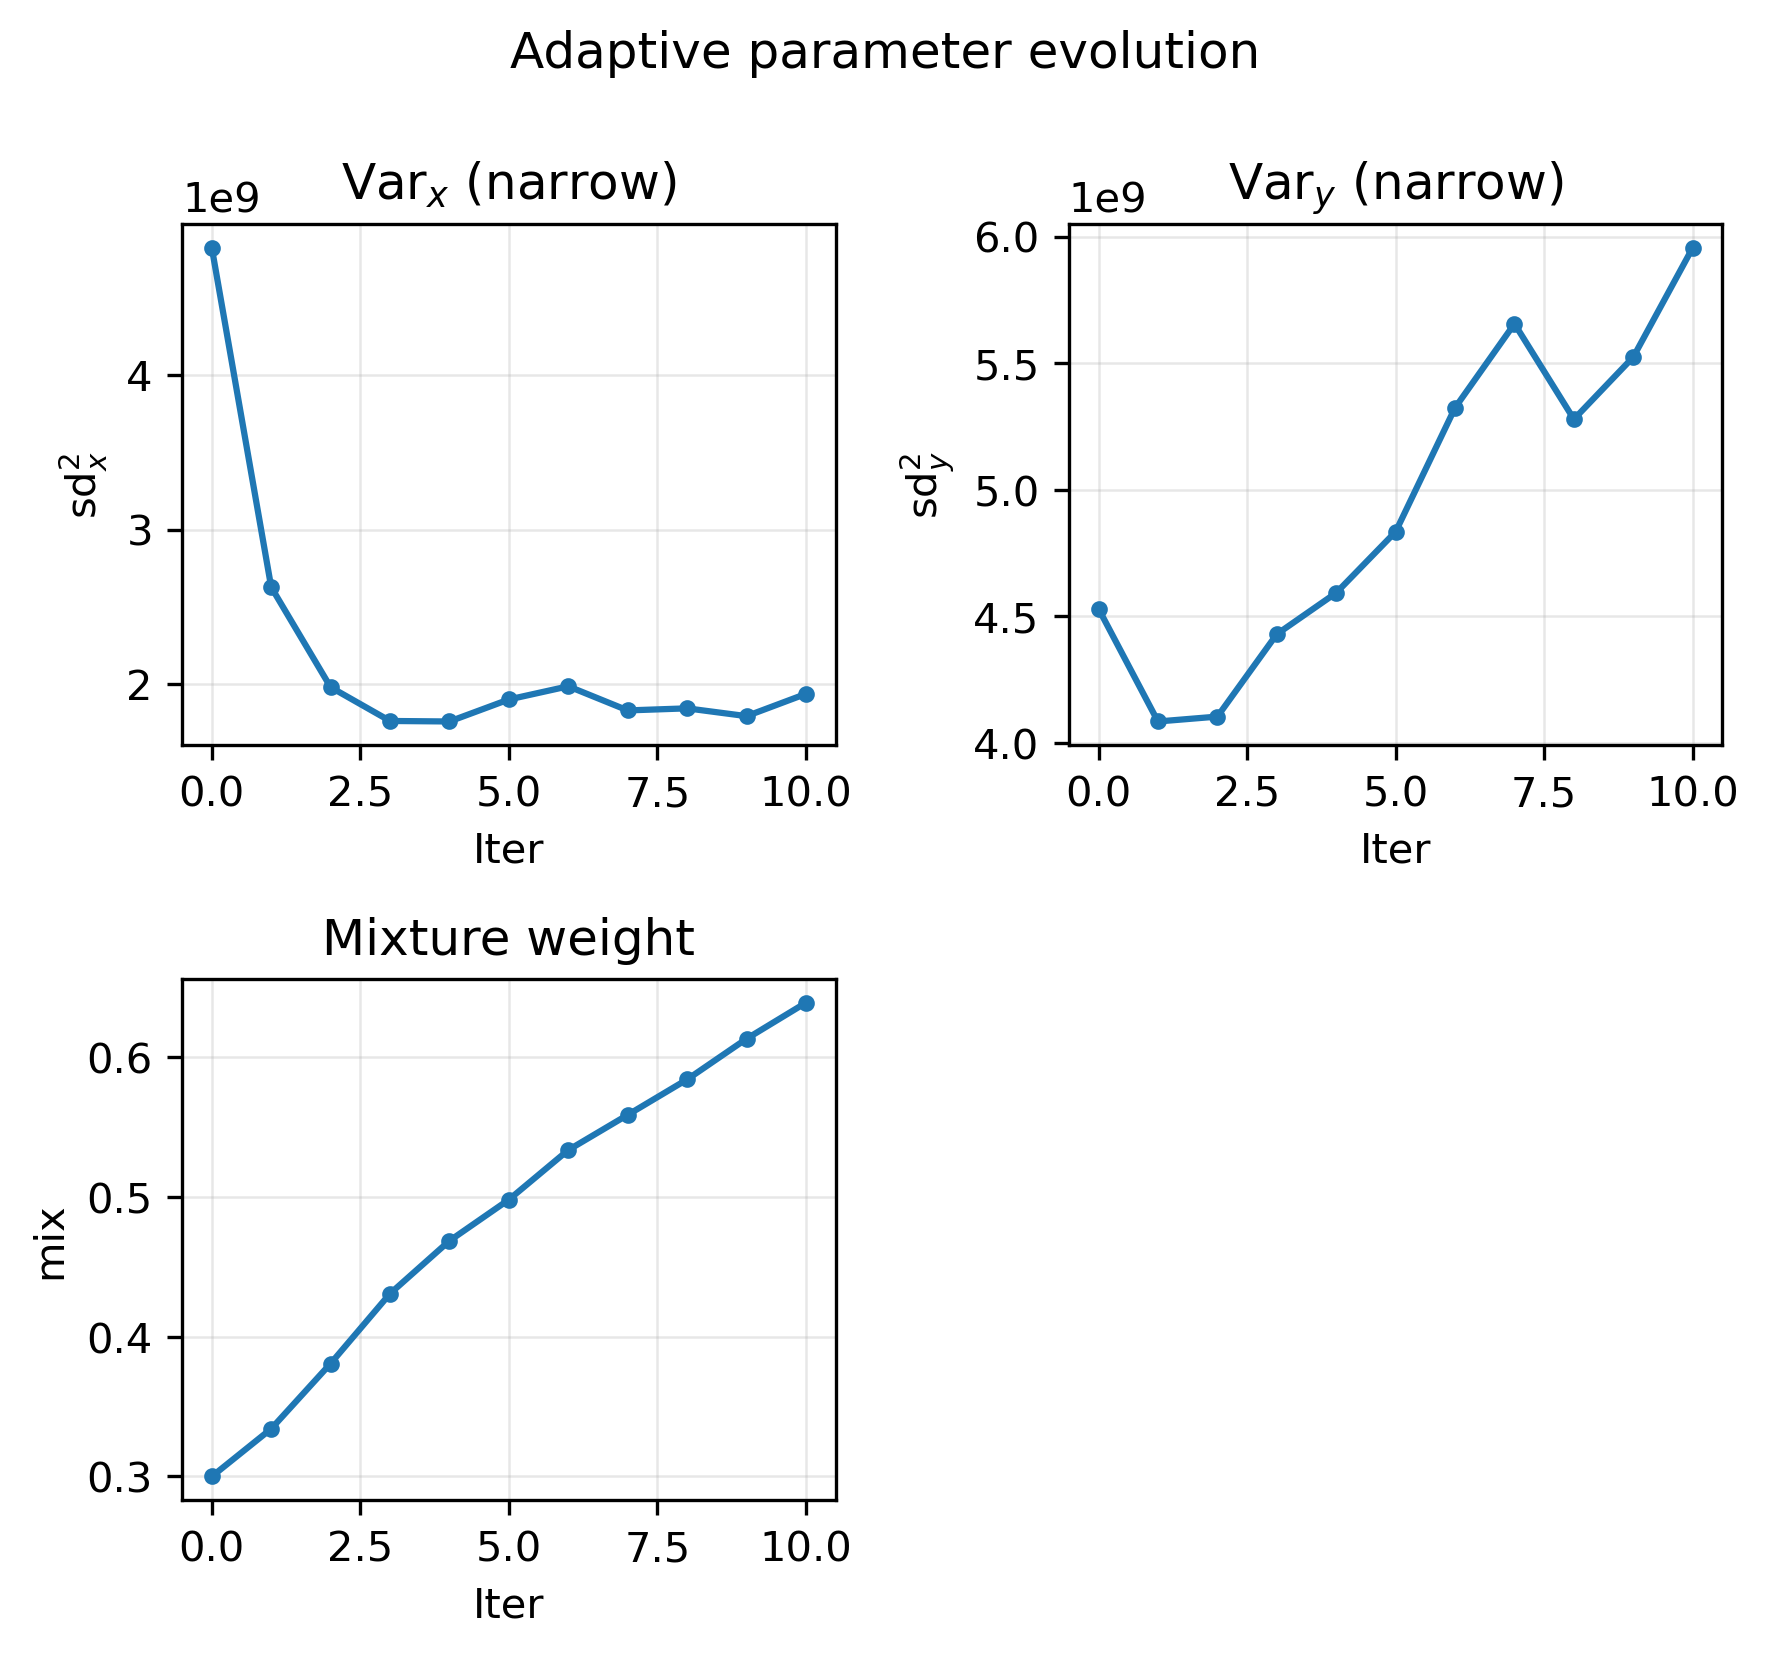

In [75]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="trinity_ais")

In [76]:
final_df = sampler.sample_final(n=14000, num_realizations=50, with_depths=True)

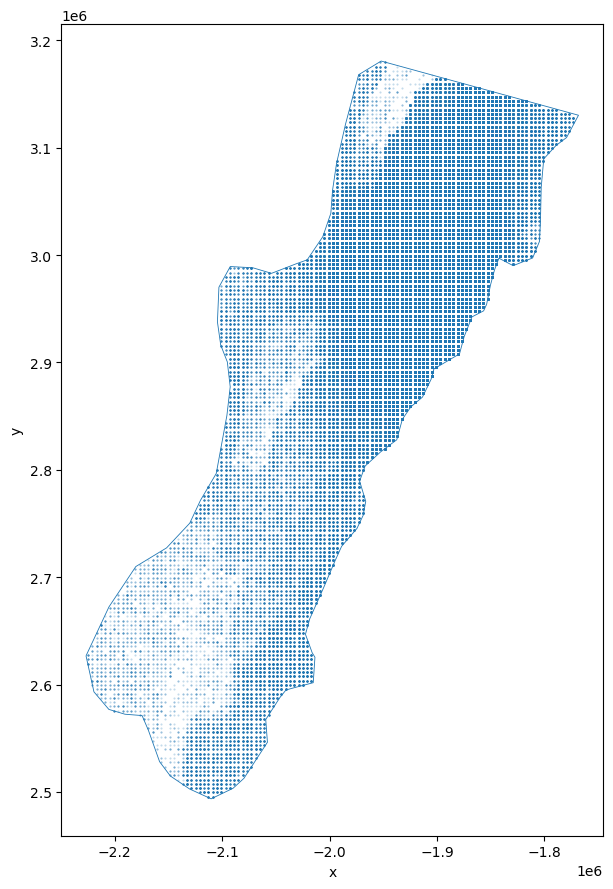

In [77]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(final_df.newx, final_df.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [78]:
adaptive_summary = summarize_depths_by_return_period(
    df=final_df,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
    use_common_min=True
)

In [82]:
m = metrics(summaries["Duwamish"],adaptive_summary)
m

n_points  rp_min_used  rp_max_used  rmse_mean  rmse_median  rmse_ci95_low  \
0      1999          2.0       2000.0    0.26614     0.322066       0.062478   

   rmse_ci95_high  rmse_ci90_low  rmse_ci90_high   me_mean  ...  me_ci95_low  \
0        0.902291       0.100999        0.582561 -0.225992  ...     0.012234   

   me_ci95_high  me_ci90_low  me_ci90_high  diff_at_maxrp_mean  \
0     -0.786045     0.020222     -0.515975           -0.467719   

   diff_at_maxrp_median  diff_at_maxrp_ci95_low  diff_at_maxrp_ci95_high  \
0             -0.765058                 0.01708                -0.940136   

   diff_at_maxrp_ci90_low  diff_at_maxrp_ci90_high  
0                0.192891                -1.000941  

[1 rows x 21 columns]

In [83]:
adaptive_summary

RP    mean_in  median_in  ci90_low_in  ci90_high_in  ci95_low_in  \
0        2   6.057776   6.061500     5.981224      6.133840     5.953638   
1        3   6.860638   6.874493     6.747772      6.934542     6.723071   
2        4   7.367780   7.368271     7.227215      7.481811     7.184858   
3        5   7.746431   7.744998     7.572280      7.897638     7.515551   
4        6   8.041775   8.048987     7.870360      8.209812     7.832574   
...    ...        ...        ...          ...           ...          ...   
1994  1996  14.204951  14.133947    13.403212     15.022013    13.145032   
1995  1997  14.205354  14.133996    13.404054     15.022269    13.146656   
1996  1998  14.205766  14.134045    13.404896     15.022525    13.148280   
1997  1999  14.206181  14.134094    13.405738     15.022781    13.149904   
1998  2000  14.206595  14.134142    13.406581     15.023037    13.151529   

      ci95_high_in  n_realizations  n_samples_per_realization  
0         6.139905              50                      14000  
1         6.946170              50                      14000  
2         7.510334              50                      14000  
3         7.901119              50                      14000  
4         8.234087              50                      14000  
...            ...             ...                        ...  
1994     15.082922              50                      14000  
1995     15.083285              50                      14000  
1996     15.083648              50                      14000  
1997     15.084011              50                      14000  
1998     15.084374              50                      14000  

[1999 rows x 9 columns]

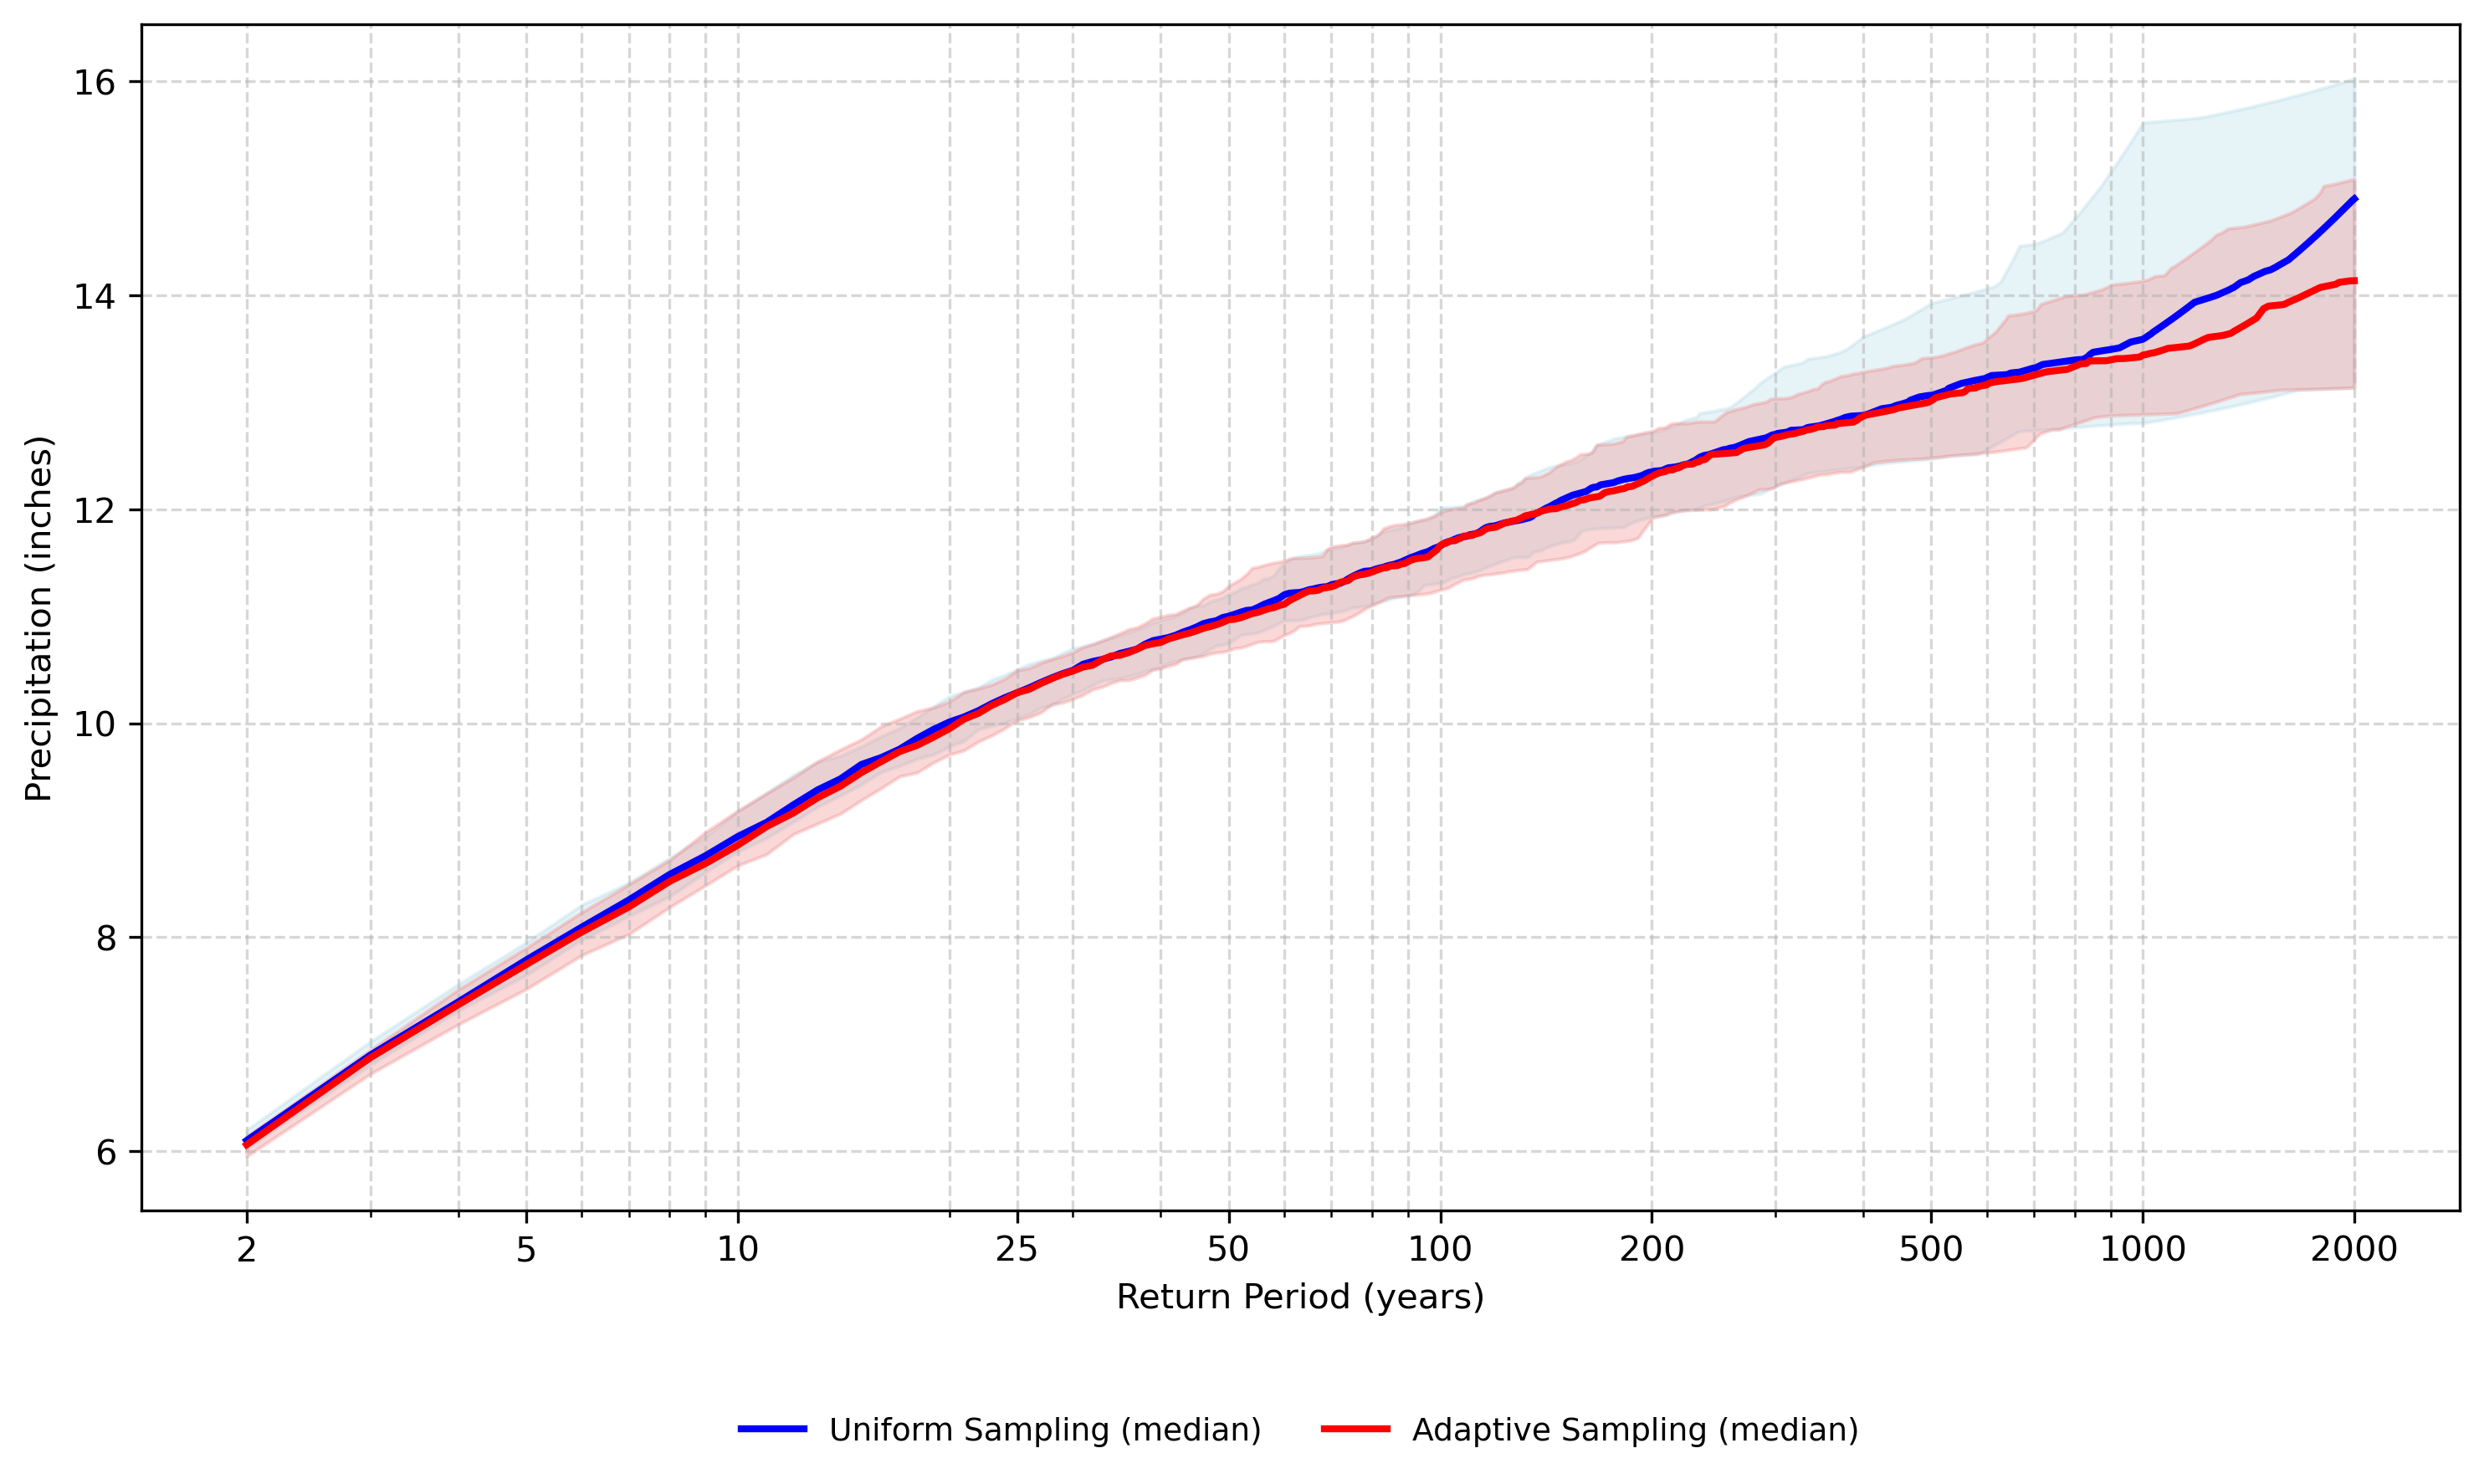

In [84]:
plot_two_return_period_summaries(
    summary1= summaries["Duwamish"],          # your first summary DataFrame
    summary2=adaptive_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Adaptive Sampling",
    title=""
)

In [86]:
watershed = watersheds["Denton"]

In [87]:
params = AdaptParams(
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"],
    sd_y_n=watershed.watershed_stats["range_y"],

    mu_x_w=watershed.watershed_stats["x"],
    mu_y_w=watershed.watershed_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"],
    sd_y_w=watershed.domain_stats["range_y"],

    rho_n=-0.1,      # correlation narrow
    rho_w=0.1,       # correlation wide
    mix=0.3,         # initial mixture weight for narrow
)

sampler = AdaptiveMixtureSampler(
    data=watershed,                   
    params=params,
    precip_cube=watershed.cumulative_precip,
    seed=42
)

# Adapt does NOT take data or seed
history = sampler.adapt(num_iterations=10, samples_per_iter=1000, depth_threshold=0.0)

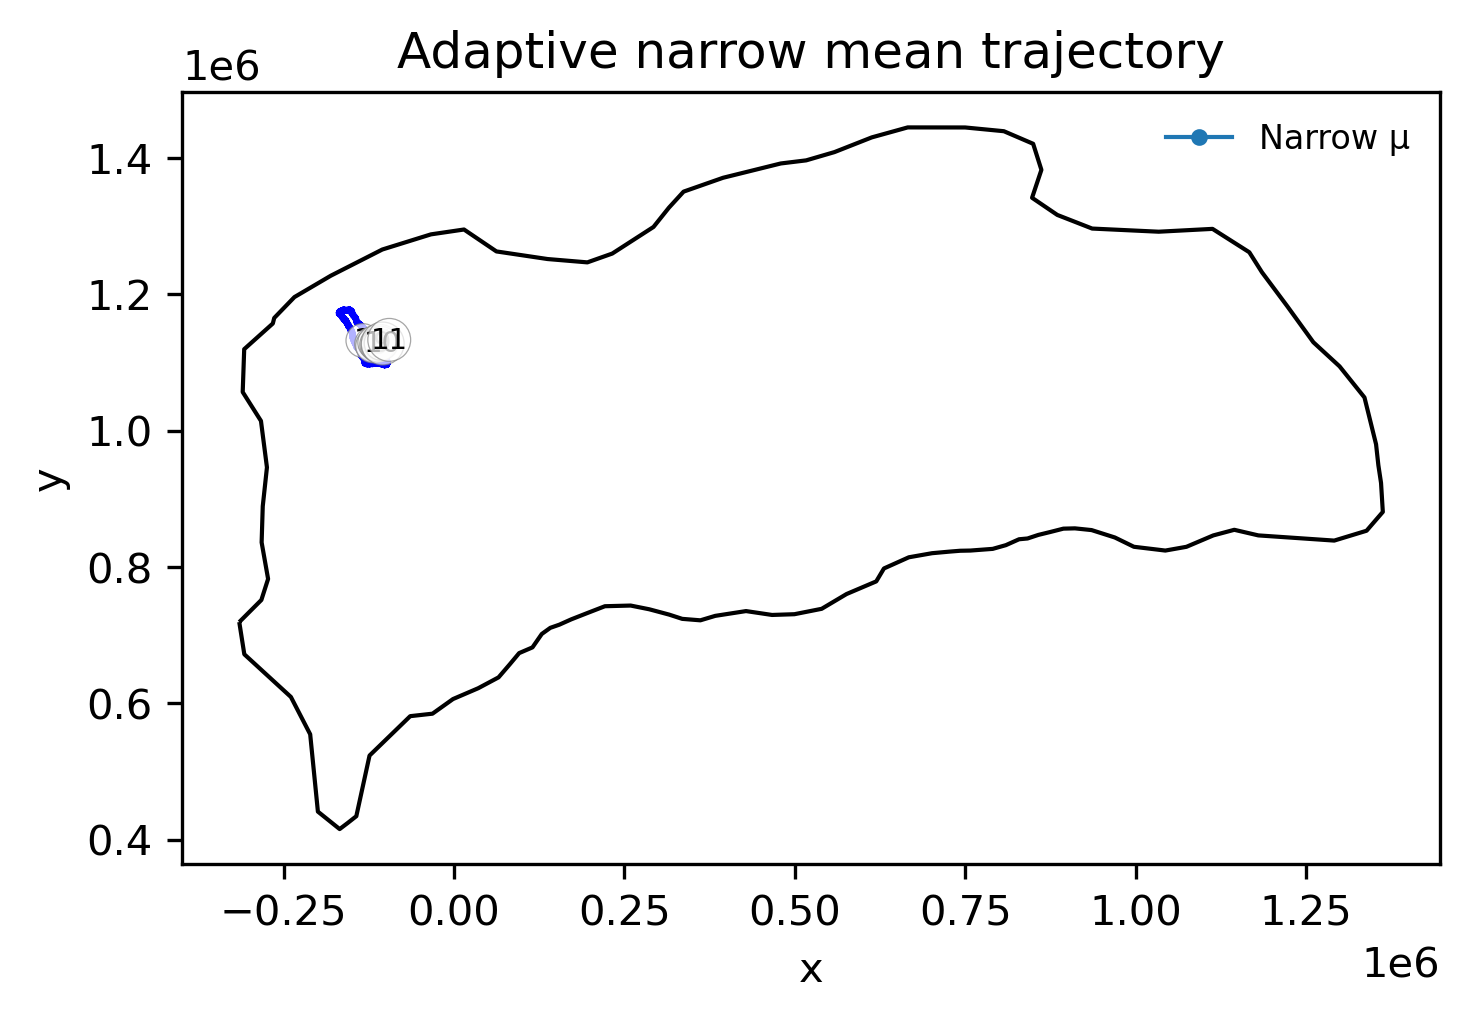

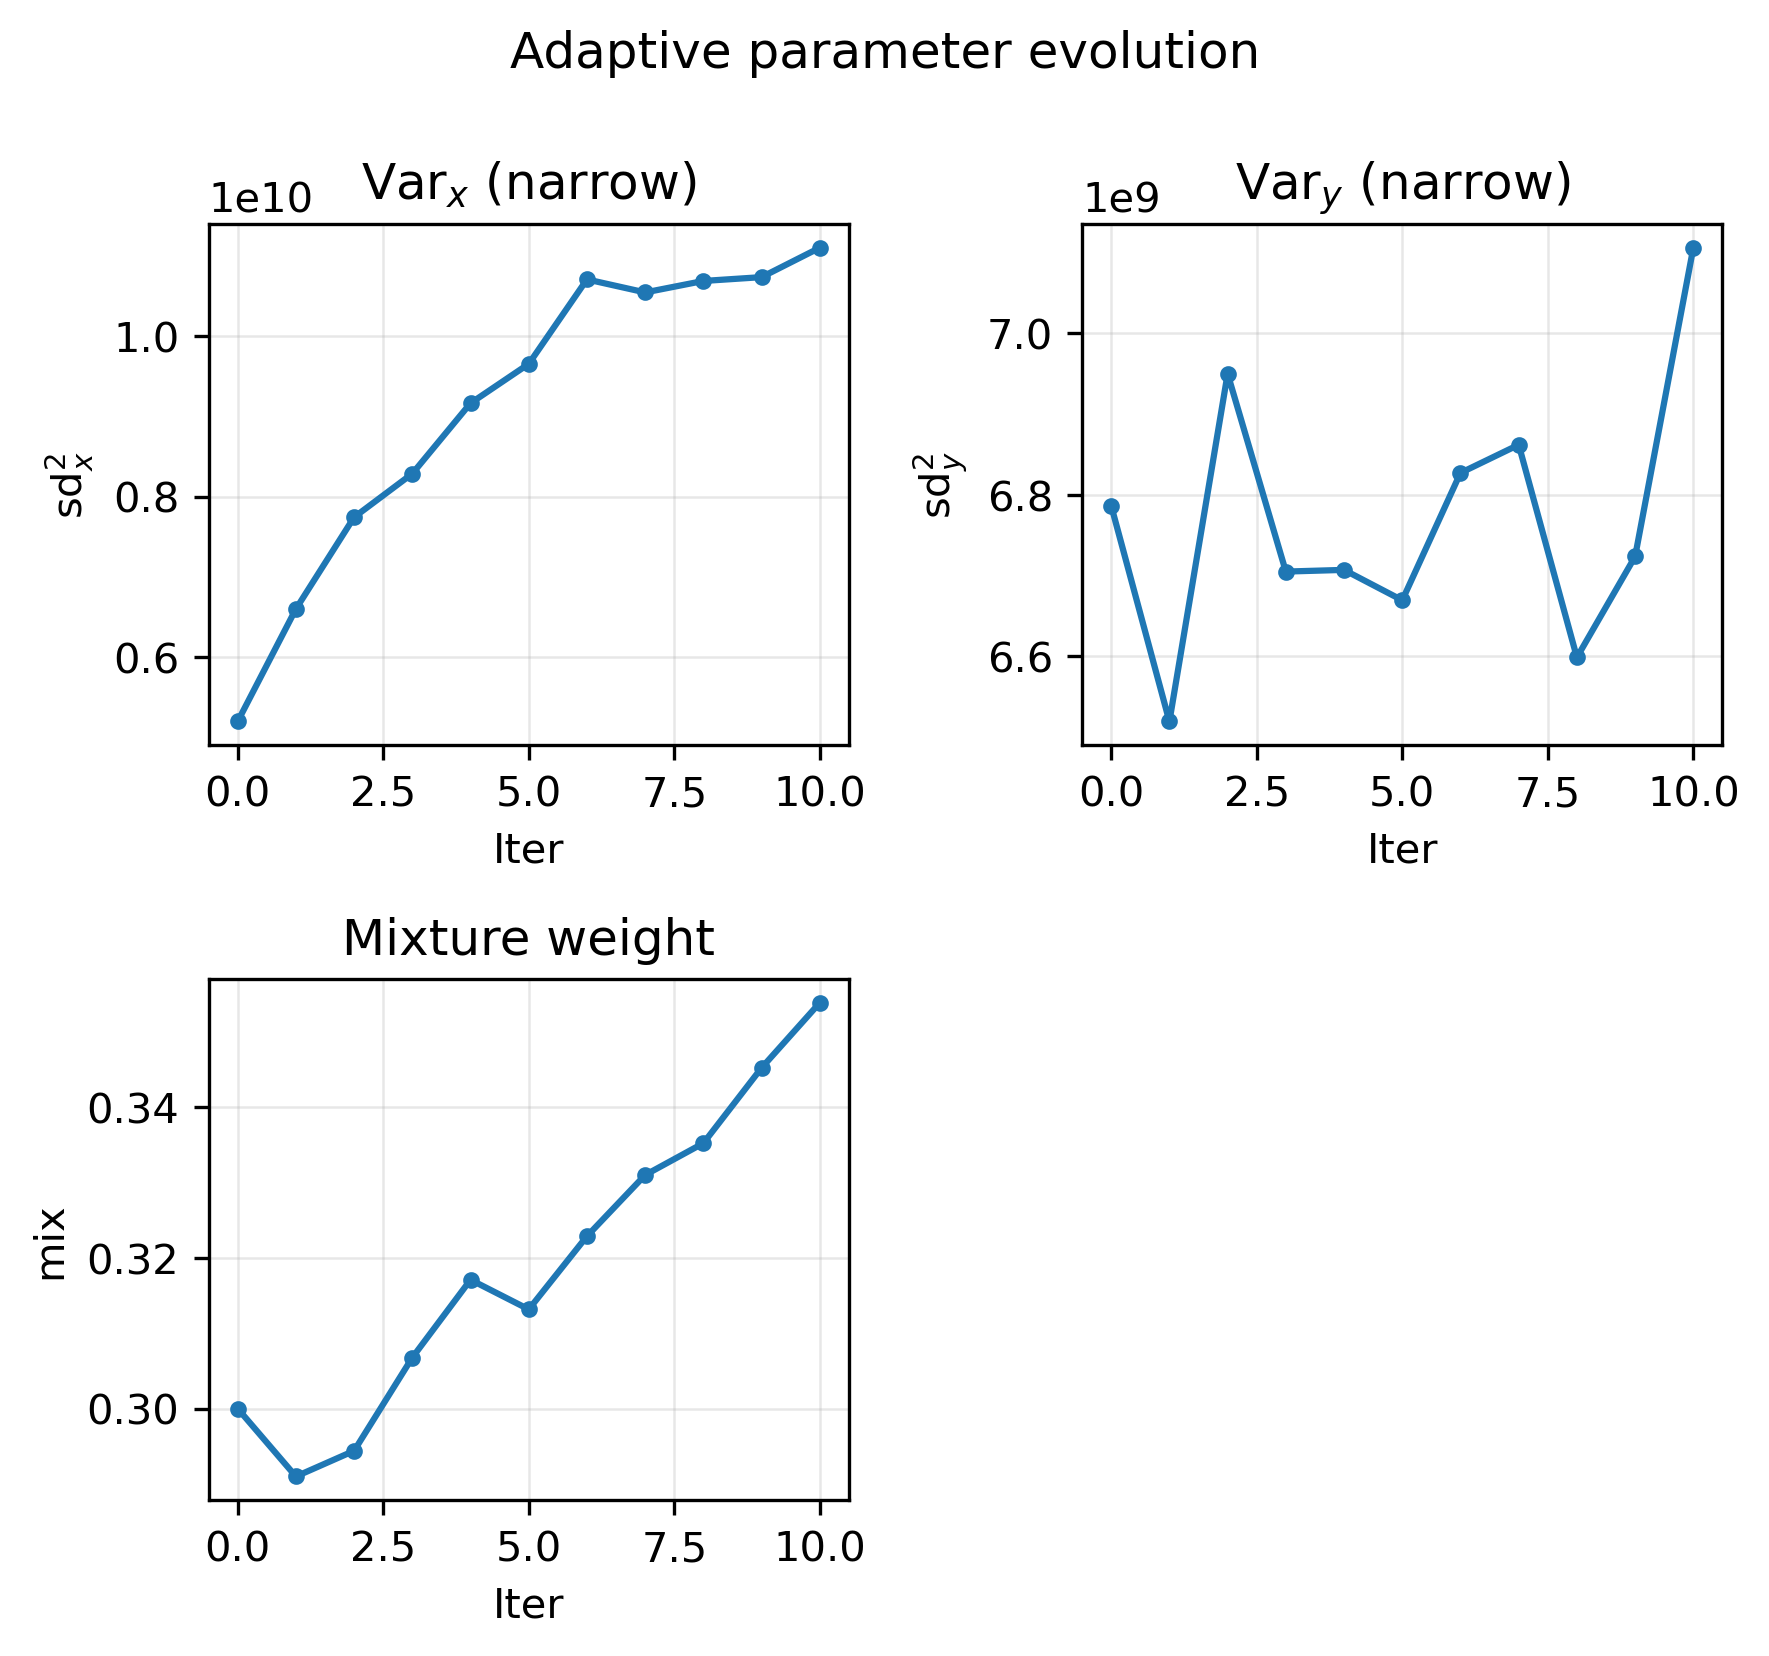

In [88]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="denton_ais")

In [89]:
final_df = sampler.sample_final(n=14000, num_realizations=50, with_depths=True)

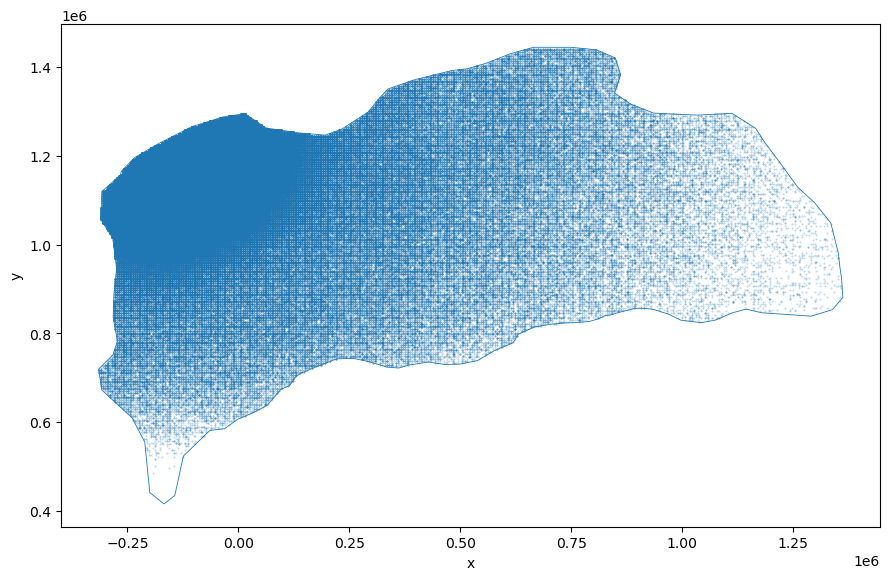

In [90]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(final_df.newx, final_df.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [91]:
adaptive_summary = summarize_depths_by_return_period(
    df=final_df,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
    use_common_min=True
)

In [92]:
m = metrics(summaries["Denton"],adaptive_summary)
m

n_points  rp_min_used  rp_max_used  rmse_mean  rmse_median  rmse_ci95_low  \
0      1999          2.0       2000.0    0.75275     0.666976       2.035093   

   rmse_ci95_high  rmse_ci90_low  rmse_ci90_high   me_mean  ...  me_ci95_low  \
0          1.9808       3.001211        1.604127  0.350703  ...     1.576586   

   me_ci95_high  me_ci90_low  me_ci90_high  diff_at_maxrp_mean  \
0     -1.632315     2.223868     -1.423652            1.011991   

   diff_at_maxrp_median  diff_at_maxrp_ci95_low  diff_at_maxrp_ci95_high  \
0              0.530197                4.503801                -2.015368   

   diff_at_maxrp_ci90_low  diff_at_maxrp_ci90_high  
0                6.560466                -1.769606  

[1 rows x 21 columns]

In [93]:
adaptive_summary

RP    mean_in  median_in  ci90_low_in  ci90_high_in  ci95_low_in  \
0        2   5.313951   5.317864     5.247599      5.396805     5.245218   
1        3   6.129188   6.133084     6.040314      6.214185     6.036039   
2        4   6.663654   6.654766     6.592919      6.748712     6.581820   
3        5   7.039669   7.029956     6.927284      7.174099     6.916042   
4        6   7.347174   7.332766     7.228285      7.513963     7.223572   
...    ...        ...        ...          ...           ...          ...   
1994  1996  28.622531  28.965406    25.920883     30.914130    23.010988   
1995  1997  28.624923  28.967466    25.921840     30.915294    23.013804   
1996  1998  28.627314  28.969526    25.922798     30.916458    23.016620   
1997  1999  28.629706  28.971587    25.923756     30.917622    23.019436   
1998  2000  28.632098  28.973647    25.924714     30.918786    23.022251   

      ci95_high_in  n_realizations  n_samples_per_realization  
0         5.405486              50                      14000  
1         6.230035              50                      14000  
2         6.768793              50                      14000  
3         7.200472              50                      14000  
4         7.518288              50                      14000  
...            ...             ...                        ...  
1994     31.019506              50                      14000  
1995     31.020628              50                      14000  
1996     31.021750              50                      14000  
1997     31.022871              50                      14000  
1998     31.023993              50                      14000  

[1999 rows x 9 columns]

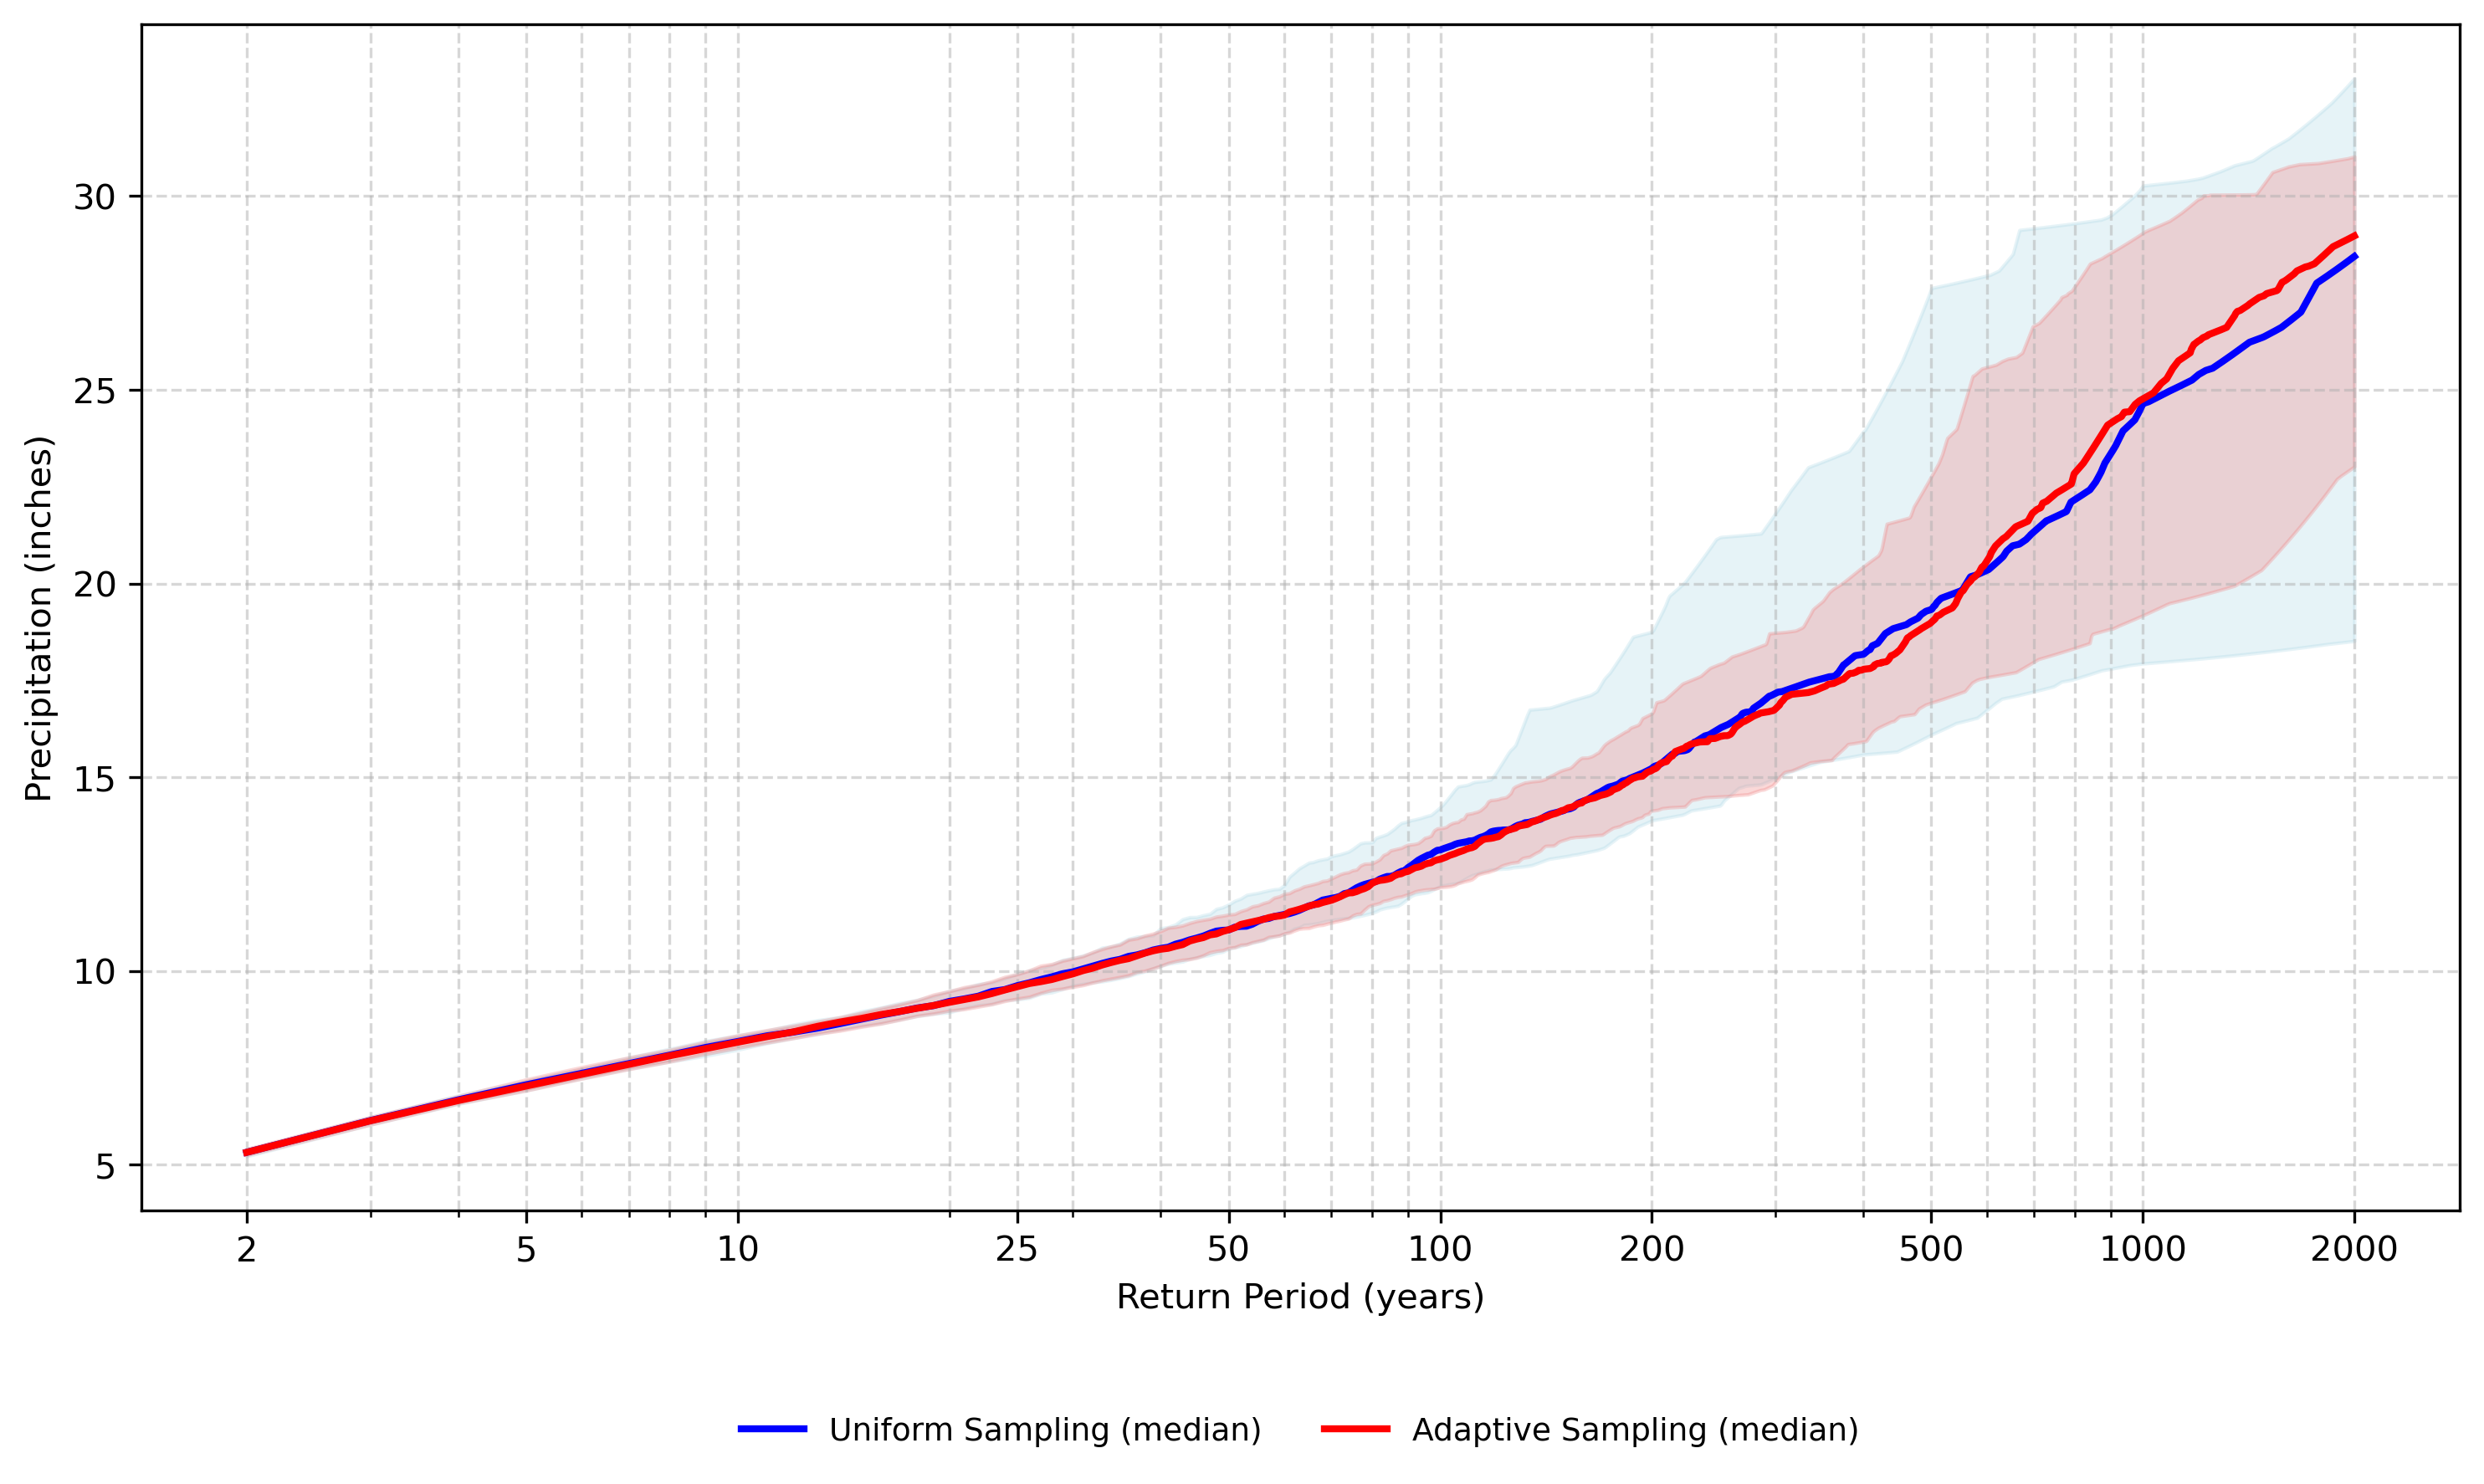

In [94]:
plot_two_return_period_summaries(
    summary1= summaries["Denton"],          # your first summary DataFrame
    summary2=adaptive_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Adaptive Sampling",
    title=""
)